In [92]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook'])
#plt.style.use(['science'])
#plt.style.use(['default'])

plt.rc('font', family='serif')

#plt.rc('text', usetex=True)

plt.rc('text.latex', preamble=r'\usepackage{xcolor}\usepackage{amsmath}\usepackage{amsfonts}')

from scipy.sparse import block_diag
from scipy.sparse import bmat
from scipy.sparse import spdiags
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy.linalg import eigh_tridiagonal
from scipy.integrate import trapezoid, simpson
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit



The aim of the code is to cross-check the results of Abhi's code in mathematica for the final values of the parameters we used in the paper.

Moreover we quantify the difference between the plot of the potentials relative to the preliminary parameters and the final ones, also in comparison w.r.t. the lattice data.

Model parameters

In [93]:
with open('zz_parameters_updated.pickle', 'rb') as parameters:
    dictionary = pickle.load(parameters)

#Define the charmonium and bottomonium masses
mc = dictionary['mc']
mb = dictionary['mb']
#mass in the bc sector
#P.N: I already include the factor 2 in this definition
#so to directly give the correct input mass value for the 
#bc case.
mred = dictionary['mbc']


#lattice parameters for the static potentials
#Cornell potential parameters
V0 = dictionary['V0']
sigma = dictionary['sigma']
gamma = dictionary['gamma'] #dimensionless

#coupling of quarkonium with the lowest threshold
g1 = dictionary['g1'] #GeV
#g2 = dictionary['g2'] #GeV


#lattice threshold value (lattice values normalized by subtracting
#two times the static-light mass).
E1 = dictionary['E1'] #GeV
#E2 = dictionary['E2'] #GeV
#Asymptodic threshold value (already shifted)
#E1c = dictionary['E1c'] #GeV

#Physical threshold values
EDbarD = dictionary['EDbarD']
EBbarB = dictionary['EBbarB']
EDB = dictionary['EDB']

#Define the kinetic coefficient
a1 = dictionary['a1']


#I now convert the previous parameters in 'fm' units
sigmafm = sigma * 1/0.197 #GeV fm^-1
gammafm = gamma * 0.197 #GeV fm

#Conversion factor
hbarc = 0.197327 

In [94]:
#I define two uniform grids: one w.r.t. the usual r variable and 
#another w.r.t. the xi variable that compactifies the domain.

#r grid
Nr = 1000
rmax = 100
rmin=0
r = np.linspace(rmin, rmax, Nr+1)
r1=r[1:-1]
dr = (rmax-rmin)/Nr


#xi grid
Nxi = 100
ximax = np.pi/2
#ximax = 1 
ximin=0
xi = np.linspace(ximin, ximax, Nxi+1)
xi1 = xi[1:-1]
dxi = (ximax-ximin)/Nxi



Define the solvers for the Schrodinger equation

In [142]:
#I now write the solver for this one channel Schrodinger
#equation.

#effective potential
def veffT(lT, mc, xi):
    return lT*(lT+1)/(mc * np.tan(xi)**2)



def solverTcc(lT, mc, Vsigmagp, k, xi, dxi):
    #Here I remove the extremes of the grid to solve the Schrodinger
    #equation
    xi1=xi[1:-1]

    #This is the main diagonal of the hamiltonian
    #For numerical reasons I add a constant to the eigenvalues.
    c=10
    dcentral=(-1/(mc * dxi**2)) * (-2 * np.cos(xi1)**4) + veffT(lT, mc, xi1)  + Vsigmagp +c
    #Here we define the two diagonals near to the main diagonal.The lenght of this
    #diagonal is the lenght of the main diagonal -1.
    dupper = (-1/(mc*dxi**2)) * (1*np.cos(xi1)**4) + 2/mc * np.cos(xi1)**4 * np.tan(xi1)/(2*dxi)
    dupper = dupper[:-1]
    dupper = np.insert(dupper,0,0)    

    dlower = (-1/(mc*dxi**2)) * (1*np.cos(xi1)**4) - 2/mc * np.cos(xi1)**4 * np.tan(xi1)/(2*dxi)
    dlower = dlower[1:]
    dlower = np.insert(dlower,len(dlower),0)
    #Here I now define the matrix to diagonalize
    diags=np.array([dlower,dcentral,dupper])
    H = spdiags(diags, np.array([-1,0,1]),
                len(dcentral), len(dcentral))
    # w,v are the eigenvalues and eigenvectors
    #P.N: this algorithm returns already normalized eigenvectors
    w, v = eigs(H, k , which='SM', maxiter = 300000)
    #Here I now add the external points to the wavefunctions
    #interp = {}
    wvf = {}

    #here I introduce the (proper wavefunction) including also the 
    #points fixed by the boundary conditions.
    for i in range(0,k):
        wvf[i] = v[:,i]/np.tan(xi1)
    #    #I define an interpolating function for the wavefunction
    #    interp[i] = CubicSpline(xi1, wvf[i])
    #    #I add a 0 at the end
    #    wvf[i] = np.insert(wvf[i],len(wvf[i]),0)
        #I extrapolate the value of the wavefunction in zero and add
        #it to the array
    #    wvf[i] = np.insert(wvf[i],0,interp[i](0))
    #    #I make all the wavefunctions positive at the origin
    #    if wvf[i][1]>= 0:
    #        wvf[i]=wvf[i]
    #    elif wvf[i][1]<0:
    #        wvf[i]=-wvf[i]


    #Here I now define the norms of the proper wavefunctions as a 1D
    #array where the i-th entry is the norm of the i-th wavefunction.
    #in this case I use the grid with the extremes included.
    norms=np.array([np.sqrt(trapezoid( (np.tan(xi1)/np.cos(xi1))**2*
            (wvf[i])**2 , x=xi1, dx= dxi)) \
         for i in range(0,k)]) 

    #Here I now define the inverse radius of the bound states in fm^-1
    invradius = np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2*
        (1/np.tan(xi1))* (wvf[i]/norms[i])**2 , x=xi1, dx= dxi) \
         for i in range(0,k)]) / hbarc

    #Radius of the bound states
    #I compute the r^2 and then I extract the sqrt.
    radius = np.sqrt(np.array([simpson((np.tan(xi1)/np.cos(xi1))**2*
        (np.tan(xi1))**2 * (wvf[i]/norms[i])**2 , x=xi1, dx= dxi) \
         for i in range(0,k)])) * hbarc


    return w.real -c , wvf, norms.real , invradius.real, radius.real




In [96]:
#Here I generalize the solver, written in xi coordinates, for a 
#three channels system.

#effective potentials
def veffsigmag(lsigma, mc, xi):
    return lsigma*(lsigma+1)/(mc *np.tan(xi)**2) + 2/(mc*np.tan(xi)**2)

def veffpig(lpi, mc, xi):
    return lpi*(lpi+1)/(mc * np.tan(xi)**2) 

def veffc(lc, mc, xi):
    return lc*(lc+1)/(mc* np.tan(xi)**2)


#kinetic term
def kineticfin(mc, dxi, xi):
    #Kinetic term for the sigma_g component of the tetraquark
    dcentralsigma = (-1/(mc * dxi**2)) * (-2 * np.cos(xi1)**4) \
        * np.ones([len(xi)])
    duppersigma = (-1/(mc*dxi**2)) * (1*np.cos(xi1)**4) + 2/mc * np.cos(xi1)**4\
          * np.tan(xi1)/(2*dxi) *np.ones([len(xi)])
    duppersigma = duppersigma[:-1]
    duppersigma = np.insert(duppersigma,0,0)

    dlowersigma = (-1/(mc*dxi**2)) * (1*np.cos(xi1)**4) - 2/mc * \
            np.cos(xi1)**4 * np.tan(xi1)/(2*dxi) *np.ones([len(xi)])

    dlowersigma = dlowersigma[1:]
    dlowersigma = np.insert(dlowersigma,len(dlowersigma),0)
    #I define the diagonals relative to the kinetic term
    diagssigma = np.array([dlowersigma,dcentralsigma,duppersigma])
    Ksigma = spdiags(diagssigma, np.array([-1,0,1]),len(xi),len(xi))

    #Kinetic term for the pi_g component of the tetraquark.
    Kpi = Ksigma

    #Kinetic term for the quarkonium component.
    Kq = Ksigma

    return block_diag((Ksigma,Kpi,Kq))


#potential term
def potentialfin(lc, lsigma, lpi, mc, VCornc, Vsigmag, Vpig, vmixdiab, xi):
    #To avoid numerical problems I add a constant to the potential
    #and then I subtract it to give the eigenvalues.
    c=10
    diagVsigma = veffsigmag(lsigma, mc, xi) + Vsigmag + c
    Vsigma = spdiags(diagVsigma, [0],len(xi),len(xi))
    diagVpi = veffpig(lpi, mc, xi) + Vpig + c
    Vpi = spdiags(diagVpi, [0],len(xi),len(xi))
    diagVc = veffc(lc, mc, xi) + VCornc + c
    Vc = spdiags(diagVc, [0],len(xi),len(xi))
    #Mixing potentials
    diagmix = (-2*np.sqrt(lsigma*(lsigma+1)))/(mc*np.tan(xi)**2)*np.ones([len(xi)])
    Vmixadiab = spdiags(diagmix, [0],len(xi),len(xi))
    dim=(len(xi),len(xi))
    null=np.zeros(dim)
    Vmixdiab = spdiags(vmixdiab, [0],len(xi),len(xi))
    #Finally I define the potential matrix as a proper block matrix
    #Also here VDbarD indicates the generic potential matrix
    #relative to a charmonium threshold
    return bmat([[Vc,Vmixdiab,null],[Vmixdiab,Vsigma,Vmixadiab],\
           [null,Vmixadiab,Vpi]])




def solverfin(lc, lsigma, lpi, mc, VCornc, Vsigmag, Vpig, Vmixdiab, k, xi, dxi):
    xi1=xi[1:-1]
    K=kineticfin(mc, dxi, xi1)
    V=potentialfin(lc, lsigma, lpi, mc, VCornc, Vsigmag, Vpig, Vmixdiab, xi1)
    H=K+V
    eigenvalues, eigenvectors = eigs(H , k, which='SM', maxiter = 400000)
    qwavred, sigmawavred, piwavred = np.split(eigenvectors,3)
    #Here I now add the external points to the wavefunctions
    #interpq = {}
    wvfq = {}
    #interpsigma = {}
    wvfsigma = {}
    #interppi = {}
    wvfpi = {}

    for i in range(0,k):
        wvfq[i] = qwavred[:,i]/np.tan(xi1)
        wvfsigma[i] = sigmawavred[:,i]/np.tan(xi1)
        wvfpi[i] = piwavred[:,i]/np.tan(xi1)
    #    #I define an interpolating function for the wavefunctions
    #    interpsigma[i] = CubicSpline(r1, wvfsigma[i])
    #    interppi[i] = CubicSpline(r1, wvfpi[i])
    #    #I add a 0 at the end
    #    wvfsigma[i] = np.insert(wvfsigma[i],len(wvfsigma[i]),0)
    #    wvfpi[i] = np.insert(wvfpi[i],len(wvfpi[i]),0)
    #    #I extrapolate the wavefunction at zero and add its value to the
    #    #array
    #    wvfsigma[i] = np.insert(wvfsigma[i],0,interpsigma[i](0))
    #    wvfpi[i] = np.insert(wvfpi[i],0,interppi[i](0))
        #In this case I do not make the wavefunctions positive at 
        #the origin to verify that for l=1 the two reps. are non 
        #vanishing at r=0 and with opposite sign.       
        
        #if wvfsigma[i][1]>= 0:
        #    wvfsigma[i]=wvfsigma[i]
        #elif wvfsigma[i][1]<0:
        #    wvfsigma[i]=-wvfsigma[i]
        #I make all the wavefunctions positive at the origin
        #if wvfpi[i][1]>= 0:
        #    wvfpi[i]=wvfpi[i]
        #elif wvfpi[i][1]<0:
        #    wvfpi[i]=-wvfpi[i]
        
    norms=np.array([np.sqrt(trapezoid((np.tan(xi1)/np.cos(xi1))**2
     * ((wvfsigma[i])**2  + (wvfpi[i])**2 + (wvfq[i])**2), x=xi1, dx= dxi)) \
         for i in range(0,k)])

    qwaveperc = np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2 * (wvfq[i]/(norms[i]))**2,\
      x=xi1, dx= dxi) for i in range(0,k)])
    sigmawaveperc = np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2 * (wvfsigma[i]/(norms[i]))**2,\
      x=xi1, dx= dxi) for i in range(0,k)])
    piwaveperc =np.array([ trapezoid((np.tan(xi1)/np.cos(xi1))**2 * (wvfpi[i]/(norms[i]))**2,\
     x=xi1, dx= dxi) for i in range(0,k)])

    invradius= np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2*\
        (1/np.tan(xi1))* ((wvfq[i]/(norms[i]))**2 + (wvfsigma[i]/(norms[i]))**2
            + (wvfpi[i]/(norms[i]))**2),  x=xi1, dx= dxi) \
         for i in range(0,k)]) / 0.197327

    radiussqr= np.sqrt(np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2*\
        (np.tan(xi1))**2 * ((wvfsigma[i]/(norms[i]))**2 + (wvfpi[i]/(norms[i]))**2
            + (wvfq[i]/(norms[i]))**2),  x=xi1, dx= dxi) \
         for i in range(0,k)]).real) * 0.197327

    #I finally subtract from the eigenvalues the constant I previously
    #added
    c=10

    #Finally I define the binding energy of the different bound state
    #w.r.t. the physical threshold.
    binding = eigenvalues -c - E1 - a1/mc   

    return eigenvalues.real - c, qwaveperc.real, sigmawaveperc.real, piwaveperc.real, wvfq, wvfsigma, wvfpi,\
          norms.real, invradius.real, radiussqr, binding.real
         

In [97]:
#To study the S-wave case for the X system we need to define a new 
#solver since the Pi_g component of the tetraquark decouples.


def veffsigmag(lsigma, mc, xi):
    return lsigma*(lsigma+1)/(mc *np.tan(xi)**2) + 2/(mc*np.tan(xi)**2)

def veffc(lc, mc, xi):
    return lc*(lc+1)/(mc* np.tan(xi)**2)


#kinetic term
def kineticsigma(mc, dxi, xi):
    #Kinetic term for the sigma_g component of the tetraquark
    dcentralsigma = (-1/(mc * dxi**2)) * (-2 * np.cos(xi1)**4) \
        * np.ones([len(xi)])
    duppersigma = (-1/(mc*dxi**2)) * (1*np.cos(xi1)**4) + 2/mc * np.cos(xi1)**4\
          * np.tan(xi1)/(2*dxi) *np.ones([len(xi)])
    duppersigma = duppersigma[:-1]
    duppersigma = np.insert(duppersigma,0,0)

    dlowersigma = (-1/(mc*dxi**2)) * (1*np.cos(xi1)**4) - 2/mc * \
            np.cos(xi1)**4 * np.tan(xi1)/(2*dxi) *np.ones([len(xi)])

    dlowersigma = dlowersigma[1:]
    dlowersigma = np.insert(dlowersigma,len(dlowersigma),0)
    #I define the diagonals relative to the kinetic term
    diagssigma = np.array([dlowersigma,dcentralsigma,duppersigma])
    Ksigma = spdiags(diagssigma, np.array([-1,0,1]),len(xi),len(xi))

    #Kinetic term for the quarkonium component.
    Kq = Ksigma

    return block_diag((Ksigma,Kq))



#potential term
def potentialsigma(lc, lsigma, mc, VCornc, Vsigmag, vmixdiab, xi):
    #To avoid numerical problems I add a constant to the potential
    #and then I subtract it to give the eigenvalues.
    c=10
    diagVsigma = veffsigmag(lsigma, mc, xi) + Vsigmag + c
    Vsigma = spdiags(diagVsigma, [0],len(xi),len(xi))
    diagVc = veffc(lc, mc, xi) + VCornc + c
    Vc = spdiags(diagVc, [0],len(xi),len(xi))
    #Mixing potentials
    Vmixdiab = spdiags(vmixdiab, [0],len(xi),len(xi))
    #Finally I define the potential matrix as a proper block matrix
    #Also here VDbarD indicates the generic potential matrix
    #relative to a charmonium threshold
    return bmat([[Vc,Vmixdiab],[Vmixdiab,Vsigma]])



def solversigma(lc, lsigma, mc, VCornc, Vsigmag, Vmixdiab, k, xi, dxi):
    xi1=xi[1:-1]
    K=kineticsigma(mc, dxi, xi1)
    V=potentialsigma(lc, lsigma, mc, VCornc, Vsigmag, Vmixdiab, xi1)
    H=K+V
    eigenvalues, eigenvectors = eigs(H , k, which='SM', maxiter = 400000)
    qwavred, sigmawavred = np.split(eigenvectors,2)
    #Here I now add the external points to the wavefunctions
    #interpq = {}
    wvfq = {}
    #interpsigma = {}
    wvfsigma = {}


    for i in range(0,k):
        wvfq[i] = qwavred[:,i]/np.tan(xi1)
        wvfsigma[i] = sigmawavred[:,i]/np.tan(xi1)
    #    #I define an interpolating function for the wavefunctions
    #    interpsigma[i] = CubicSpline(r1, wvfsigma[i])
    #    interppi[i] = CubicSpline(r1, wvfpi[i])
    #    #I add a 0 at the end
    #    wvfsigma[i] = np.insert(wvfsigma[i],len(wvfsigma[i]),0)
    #    wvfpi[i] = np.insert(wvfpi[i],len(wvfpi[i]),0)
    #    #I extrapolate the wavefunction at zero and add its value to the
    #    #array
    #    wvfsigma[i] = np.insert(wvfsigma[i],0,interpsigma[i](0))
    #    wvfpi[i] = np.insert(wvfpi[i],0,interppi[i](0))
        #In this case I do not make the wavefunctions positive at 
        #the origin to verify that for l=1 the two reps. are non 
        #vanishing at r=0 and with opposite sign.       
        
        #if wvfsigma[i][1]>= 0:
        #    wvfsigma[i]=wvfsigma[i]
        #elif wvfsigma[i][1]<0:
        #    wvfsigma[i]=-wvfsigma[i]
        #I make all the wavefunctions positive at the origin
        #if wvfpi[i][1]>= 0:
        #    wvfpi[i]=wvfpi[i]
        #elif wvfpi[i][1]<0:
        #    wvfpi[i]=-wvfpi[i]
        
    norms=np.array([np.sqrt(trapezoid((np.tan(xi1)/np.cos(xi1))**2
     * ((wvfsigma[i])**2  + (wvfq[i])**2), x=xi1, dx= dxi)) \
         for i in range(0,k)])

    qwaveperc = np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2 * (wvfq[i]/(norms[i]))**2,\
      x=xi1, dx= dxi) for i in range(0,k)])
    sigmawaveperc = np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2 * (wvfsigma[i]/(norms[i]))**2,\
      x=xi1, dx= dxi) for i in range(0,k)])
    

    invradius= np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2*\
        (1/np.tan(xi1))* ((wvfq[i]/(norms[i]))**2 + (wvfsigma[i]/(norms[i]))**2)
        ,  x=xi1, dx= dxi) \
         for i in range(0,k)]) / 0.197327

    radiussqr= np.sqrt(np.array([trapezoid((np.tan(xi1)/np.cos(xi1))**2*\
        (np.tan(xi1))**2 * ((wvfsigma[i]/(norms[i]))**2 
            + (wvfq[i]/(norms[i]))**2),  x=xi1, dx= dxi) \
         for i in range(0,k)]).real )* 0.197327

    #I finally subtract from the eigenvalues the constant I previously
    #added
    c=10

    #Finally I define the binding energy of the different bound states
    binding = eigenvalues -c - E1 - a1/mc

    return eigenvalues.real - c, qwaveperc.real, sigmawaveperc.real, wvfq, wvfsigma,\
          norms.real, invradius.real, radiussqr, binding.real
           


Define the static potentials

In [98]:
#I define the Cornell potential

#Cornell potential
def vCornc(V0, sigma, gamma, xi):
    return V0 + sigma*np.tan(xi) + gamma/np.tan(xi)

VCornc = vCornc(V0, sigma, gamma, xi1)

#Mixing potential
#here I define a mixing potential consisting of a linear+flat+
#exponential part.

#extremes of the flat region
rin = 0.95 #fm
xiin = np.arctan(rin/0.197327)
rfin = 1.51 #fm
xifin = np.arctan(rfin/0.197327)

gin = rin/0.197327

def vmixdiab1(g, ximixpart1):
    return g/gin * np.tan(ximixpart1)

def vmixdiab2(g, ximixpart2):
    return g * np.ones(len(ximixpart2))

#Parameter determined in Mathematica by asking for the continuity
#of the potential at r=rfin.
A = 1.02456 #GeV
#Sommer scale: 0.5 fm, phenomenological parameter
d0= 0.5 / 0.197327 #GeV^-1

def vmixdiab3(g, ximixpart3):
    return A * np.exp(-np.tan(ximixpart3)/d0)


def vmixdiab(g, Nxi):

    ximixpart1 = np.linspace(ximin, xiin, int(xiin *Nxi/(ximax-ximin))+1)[1:]
    ximixpart2 = np.linspace(xiin, xifin, int((xifin-xiin) *Nxi/(ximax-ximin))+2)[1:]
    ximixpart3 = np.linspace(xifin, ximax, int((ximax-xifin) *Nxi/(ximax-ximin))+2)[1:-1]

    Vmixpart1= vmixdiab1(g, ximixpart1)
    Vmixpart2= vmixdiab2(g, ximixpart2)
    Vmixpart3= vmixdiab3(g, ximixpart3)
    Vmixfin = np.concatenate((Vmixpart1,Vmixpart2,Vmixpart3))

    return Vmixfin

Vmixdiab = vmixdiab(g1, Nxi)


#I define the the tetraquark potentials
def vsmallxi(k8,delta,A,B,xi):
    return k8/np.tan(xi) + delta + A*np.tan(xi)**2 + B*np.tan(xi)**4

def vlargexi(F,reff,E1,xi):
    return F*np.exp(-(np.tan(xi)/reff))/np.tan(xi)**2 + E1

def Vrepg(k8,delta,A,B,F,reff,E1,xismall,xilarge, shift):
    Vsmall = vsmallxi(k8,delta,A,B,xismall)
    Vlarge = vlargexi(F,reff,E1,xilarge)
    Vrepg = np.concatenate((Vsmall,Vlarge)) + shift
    return Vrepg

def Vtetrxi(k3,delta,A,B,F,reff,ximatch,E1,shift):
    xismall = np.linspace(ximin,ximatch,int(ximatch*Nxi/
                                                 (ximax-ximin))+1)[1:]
    xilarge = np.linspace(ximatch,ximax,int((ximax-ximatch)
                                                 *Nxi/(ximax-ximin))+2)[1:-1]

    V = Vrepg(k3,delta,A,B,F,
                   reff,E1,xismall,xilarge, shift)

    return V




Tcc case

I define the parameters of the potential

In [99]:
#tetraquark potentials parameters for a system with an heavy
#quark pair QQ. 
# #I make all the wavefunctions positive at the origin
#small r parameters
k3 = -0.12 #dimensionless

Asigmagp = 0.196698 #GeV^3

Bsigmagp = -0.0449009 #GeV^5


#two-pion exchange mass parameter
reffp = 1/0.3 #GeV^-1


I condsider the final critical mass value: -0.478 GeV

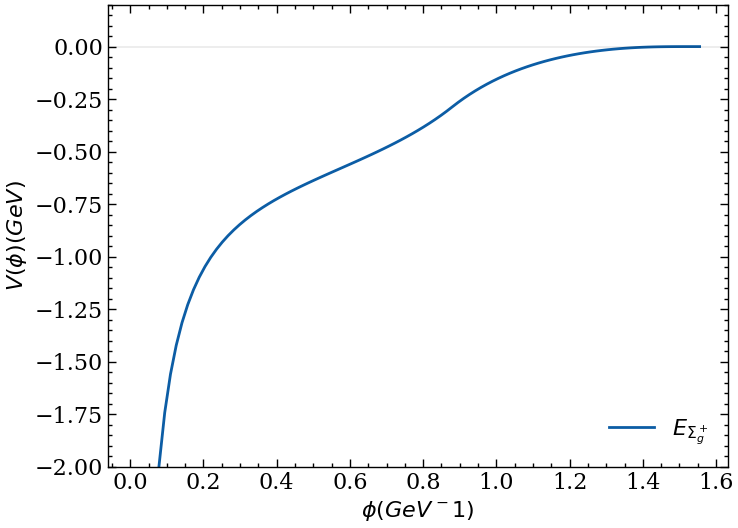

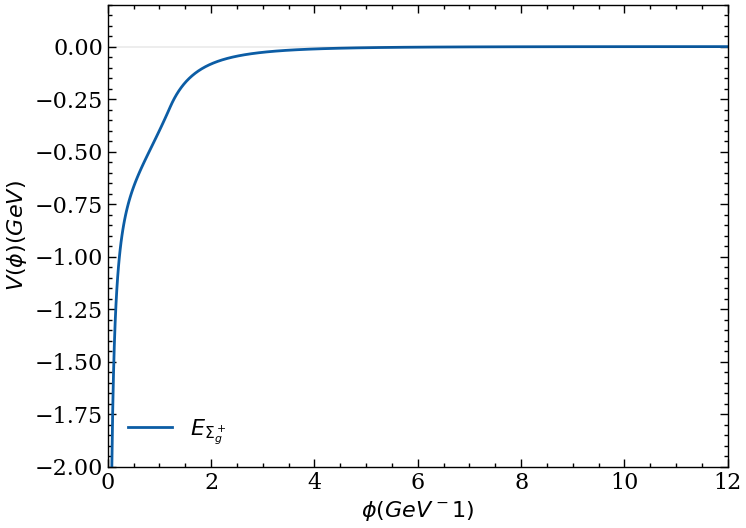

In [100]:
#I define the large r parameters of the tetraquark potential.

deltap = -0.478 # GeV

Fsigmagp = -0.608724 #GeV^-1

rmatchsigmap = 1.2139 #GeV^-1
ximatchsigmap = np.arctan(rmatchsigmap)


Vsigmagp = Vtetrxi(k3,deltap,Asigmagp,0,
                   Fsigmagp,reffp,ximatchsigmap,0,0)


#print(ximatchsigmap)
#print(len(Vsigmagp))

#I plot the potential in this xi coordinate
plt.plot(xi1,Vsigmagp, label=r'$E_{\Sigma_g^+}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
#plt.xlim(0,12)
plt.ylim(-2,0.2)
plt.xlabel(r'$\phi (GeV^-1)$')
plt.ylabel(r'$V(\phi) (GeV)$')
#plt.grid()
plt.legend()
plt.show()


#and in the r coordinate
plt.plot(np.tan(xi1),Vsigmagp, label=r'$E_{\Sigma_g^+}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
plt.xlim(0,12)
plt.ylim(-2,0.2)
plt.xlabel(r'$\phi (GeV^-1)$')
plt.ylabel(r'$V(\phi) (GeV)$')
#plt.grid()
plt.legend()
plt.show()


#This potential seems correct compared with the Mathematica one.

I solve the Schrodiger equations in the charm sector

In [101]:
#S-wave Schrodinger equation
Vsigmagp = Vtetrxi(k3,deltap,Asigmagp,0,
                   Fsigmagp,reffp,ximatchsigmap,0,0)

eigenvalueT, wvfT, normsT, invradiusT, radiusT = solverTcc(0, 
            mc, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueT)
#print(eigenvalueT - 10)

print('Binding energy w.r.t. the physical threshold (KeV)')
print((eigenvalueT - a1/mc)*10**6)

print('Mass of the state (GeV)')
print(EDbarD + (eigenvalueT - a1/mc))

print('Bound state radius from 1/r (fm)')
print(1/invradiusT)

print('Bound state radius (fm)')
print(radiusT)

print('Scattering lenght exstimation (fm)')
print(np.sqrt(1/(mc*-(eigenvalueT - a1/mc)))* hbarc)

#results very close to Abhi's code.


Binding energy w.r.t. the static threshold (GeV)
[-0.00090299]
Binding energy w.r.t. the physical threshold (KeV)
[-315.09725411]
Mass of the state (GeV)
[3.9456849]
Bound state radius from 1/r (fm)
[1.13749189]
Bound state radius (fm)
[3.31823344]
Scattering lenght exstimation (fm)
[7.91408411]


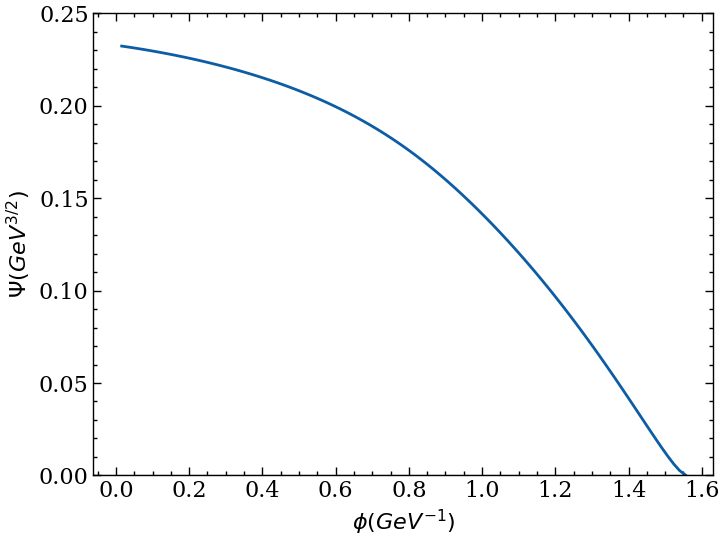

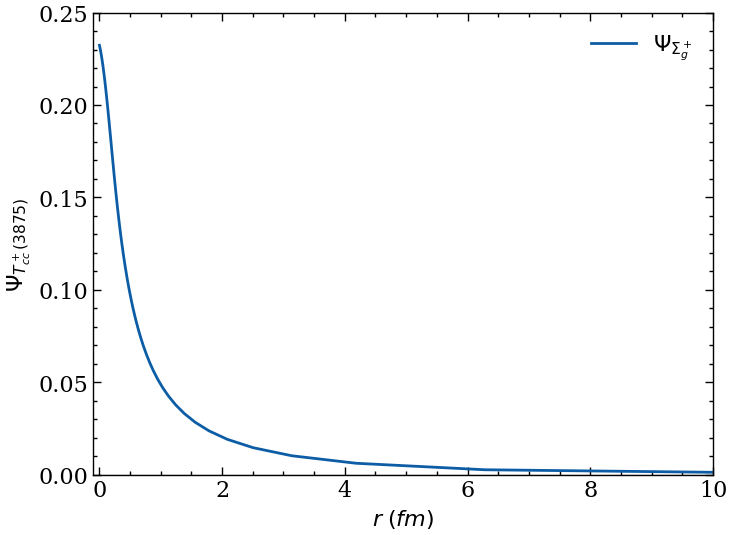

In [102]:
#I plot the wavefunction in xi and r coordinates.

#xi coordinates
plt.plot(xi1,-wvfT[0].real/normsT[0].real, label=r'$E_{QQ}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
#plt.xlim(0,12)
plt.ylim(0,0.25)
plt.xlabel(r'$\phi (GeV^{-1})$')
plt.ylabel(r'$\Psi (GeV^{3/2}) $')
#plt.grid()
#plt.legend()
plt.show()

#plot the wavefunction in the 'usual' coordinates.

plt.plot(np.tan(xi1)*0.197327,-wvfT[0].real/normsT[0].real, label=r'$\Psi_{\Sigma_g^+}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
plt.xlim(-0.1,10)
plt.ylim(0,0.25)
plt.xlabel(r'$r \;(fm)$')
plt.ylabel(r'$\Psi_{T_{cc}^+(3875)}$')
#plt.grid()
plt.legend()
plt.show()




In [103]:
#Here I solve the P-wave and D-wave coupled equation and verify that
#I do not have any bound state solution below threshold.

#P-wave Schrodinger equation
eigenvalueTp, wvfTp, normsTp, invradiusTp, radiusTp = solverTcc(1, 
            mc, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTp)
#print(eigenvalueT - 10)


#D-wave Schrodinger equation
eigenvalueTd, wvfTd, normsTd, invradiusTd, radiusTd = solverTcc(2, 
            mc, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTd)
#print(eigenvalueT - 10)


Binding energy w.r.t. the static threshold (GeV)
[0.00042113]
Binding energy w.r.t. the static threshold (GeV)
[0.00095095]


I solve the Schrodinger equation in the bottom sector

In [104]:
#I now try to solve the Schrodinger equation for the Tbb state.

Vsigmagp = Vtetrxi(k3,deltap,Asigmagp,0,
                   Fsigmagp,reffp,ximatchsigmap,0,0)

eigenvalueTb, wvfTb, normsTb, invradiusTb, radiusTb = solverTcc(0, 
            mb, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTb)
#print(eigenvalueT - 10)

print('Binding energy w.r.t. the physical threshold (MeV)')
print((eigenvalueTb - a1/mb)*10**3)

print('Mass of the state (GeV)')
print(EBbarB + (eigenvalueTb - a1/mb))

print('Bound state radius from 1/r (fm)')
print(1/invradiusTb)

print('Bound state radius (fm)')
print(radiusTb)

#results very close to Abhi's code.


Binding energy w.r.t. the static threshold (GeV)
[-0.11509036]
Binding energy w.r.t. the physical threshold (MeV)
[-114.87204355]
Mass of the state (GeV)
[10.51212796]
Bound state radius from 1/r (fm)
[0.19973867]
Bound state radius (fm)
[0.32477803]


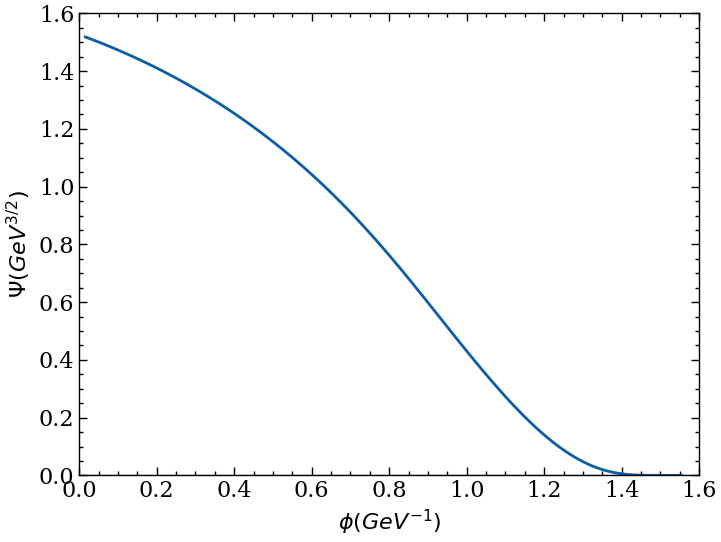

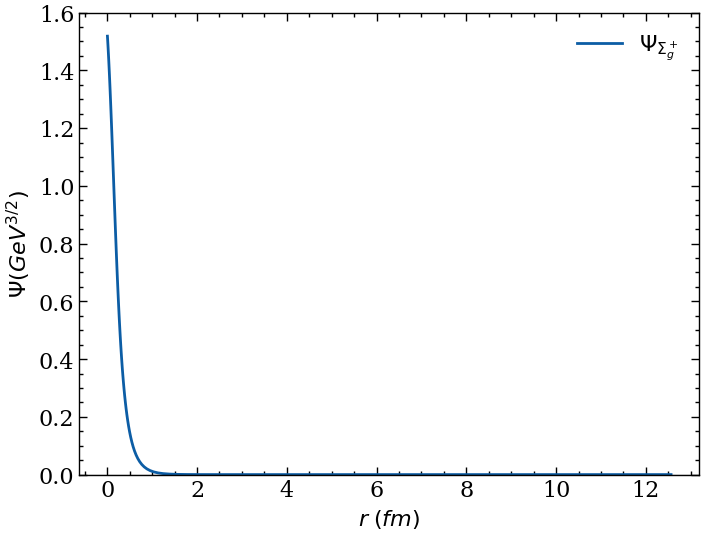

In [105]:
#I plot the wavefunction in xi and r coordinates.

#xi coordinates
plt.plot(xi1,-wvfTb[0].real/normsTb[0].real, label=r'$E_{QQ}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
plt.xlim(0,1.6)
plt.ylim(0,1.6)
plt.xlabel(r'$\phi (GeV^{-1})$')
plt.ylabel(r'$\Psi (GeV^{3/2}) $')
#plt.grid()
#plt.legend()
plt.show()

#plot the wavefunction in the 'usual' coordinates.

plt.plot(np.tan(xi1)*0.197327,-wvfTb[0].real/normsTb[0].real, label=r'$\Psi_{\Sigma_g^+}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
#plt.xlim(0,1.6)
plt.ylim(0,1.6)
plt.xlabel(r'$r \;(fm)$')
plt.ylabel(r'$\Psi (GeV^{3/2}) $')
#plt.grid()
plt.legend()
plt.show()




In [106]:
#I now verify that there are no other bound state solutions in the
#S-wave sector below threshold.

eigenvalueTb, wvfTb, normsTb, invradiusTb, radiusTb = solverTcc(0, 
            mb, Vsigmagp, 2, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTb)

#the algorithm does not converge to any solution.

Binding energy w.r.t. the static threshold (GeV)
[-1.15090361e-01  4.23235322e-05]


In [107]:
#I simlarly solve the Schrodinger equation for P-wave, D-wave and
#verify that there are no bound state solutions.

#Here I solve the P-wave and D-wave coupled equation and verify that
#I do not have any bound state solution below threshold.

#P-wave Schrodinger equation
eigenvalueTbp, wvfTbp, normsTbp, invradiusTbp, radiusTbp = solverTcc(1, 
            mb, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTbp)
#print(eigenvalueT - 10)


#D-wave Schrodinger equation
eigenvalueTbd, wvfTbd, normsTbd, invradiusTbd, radiusTbd = solverTcc(2, 
            mb, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTbd)
#print(eigenvalueT - 10)


#There are no bound state solutions as expected.


Binding energy w.r.t. the static threshold (GeV)
[0.00015632]
Binding energy w.r.t. the static threshold (GeV)
[0.00035314]


I finally solve the Schrodinger equation in the bc sector 

In [108]:
eigenvalueTbc, wvfTbc, normsTbc, invradiusTbc, radiusTbc = solverTcc(0, 
            mred, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTbc)
#print(eigenvalueT - 10)

print('Binding energy w.r.t. the physical threshold (MeV)')
print((eigenvalueTbc - a1/mred)*10**3)

print('Mass of the state (GeV)')
print(EDB + (eigenvalueTbc - a1/(mred)))

print('Bound state radius from 1/r (fm)')
print(1/invradiusTbc)

print('Bound state radius (fm)')
print(radiusTbc)

#results very close to Abhi's code.


Binding energy w.r.t. the static threshold (GeV)
[-0.02344202]
Binding energy w.r.t. the physical threshold (MeV)
[-23.03891237]
Mass of the state (GeV)
[7.26396109]
Bound state radius from 1/r (fm)
[0.37363883]
Bound state radius (fm)
[0.73217132]


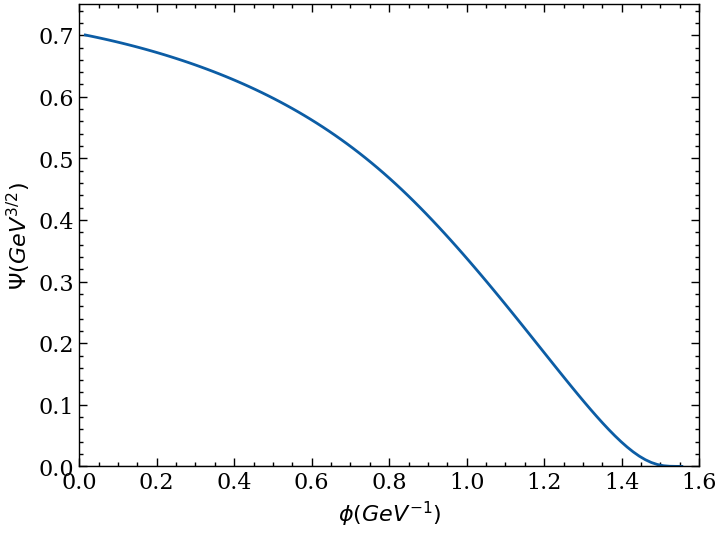

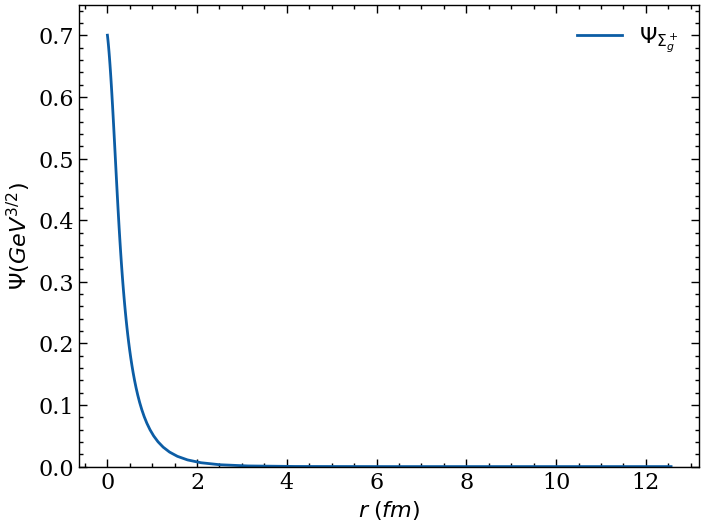

In [109]:
#I plot the wavefunction in xi and r coordinates.

#xi coordinates
plt.plot(xi1,wvfTbc[0].real/normsTbc[0].real, label=r'$E_{QQ}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
plt.xlim(0,1.6)
plt.ylim(0,0.75)
plt.xlabel(r'$\phi (GeV^{-1})$')
plt.ylabel(r'$\Psi (GeV^{3/2}) $')
#plt.grid()
#plt.legend()
plt.show()

#plot the wavefunction in the 'usual' coordinates.

plt.plot(np.tan(xi1)*0.197327,wvfTbc[0].real/normsTbc[0].real, label=r'$\Psi_{\Sigma_g^+}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
#plt.xlim(0,1.6)
plt.ylim(0,0.75)
plt.xlabel(r'$r \;(fm)$')
plt.ylabel(r'$\Psi (GeV^{3/2}) $')
#plt.grid()
plt.legend()
plt.show()




In [110]:
#I now verify that there are no other bound state solutions in the
#S-wave sector below threshold.

eigenvalueTbc, wvfTbc, normsTbc, invradiusTbc, radiusTbc = solverTcc(0, 
            mred, Vsigmagp, 2, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTbc)

#the algorithm does not converge to any solution.

Binding energy w.r.t. the static threshold (GeV)
[-2.34420193e-02  8.68191903e-05]


In [111]:
#I simlarly solve the Schrodinger equation for P-wave, D-wave and
#verify that there are no bound state solutions.

#Here I solve the P-wave and D-wave coupled equation and verify that
#I do not have any bound state solution below threshold.

#P-wave Schrodinger equation
eigenvalueTbcp, wvfTbcp, normsTbcp, invradiusTbcp, radiusTbcp = solverTcc(1, 
            mred, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTbcp)
#print(eigenvalueT - 10)


#D-wave Schrodinger equation
eigenvalueTbcd, wvfTbcd, normsTbcd, invradiusTbcd, radiusTbcd = solverTcc(2, 
            mred, Vsigmagp, 1, xi, dxi)

#Grid details: # of points = 200

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueTbcd)
#print(eigenvalueT - 10)


#There are no bound state solutions as expected.


Binding energy w.r.t. the static threshold (GeV)
[0.00028873]
Binding energy w.r.t. the static threshold (GeV)
[0.00065205]


X case

I define the parameters of the tetraquark potentials potentials

In [112]:
#tetraquark potentials parameters for a system with an heavy
#quark pair QbarQ. 

k8 = 0.037 # dimensionless

Asigmag = 0.00645415 #GeV^3

Bsigmag = 0.00178072 #GeV^5

Apig = 0.0725938 #GeV^3

Bpig = -0.00507409 #GeV^5


#two-pion exchange mass parameter
reffp = 1/0.3 #GeV^-1



I consider the final critical mass valus: -0.228 GeV

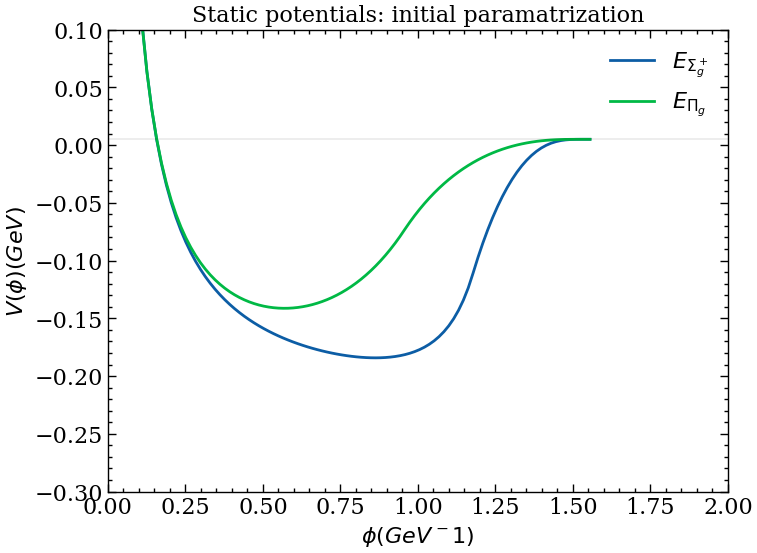

In [113]:
deltat = -0.228 #GeV

Fsigmag = -1.43962 #GeV^-1
rmatchsigmag = 2.4444 #GeV^-1
ximatchsigmag = np.arctan(rmatchsigmag)

Fpig = -0.251049 #GeV^-1
rmatchpig = 1.4462 #GeV^-1
ximatchpig = np.arctan(rmatchpig)

Vsigmag = Vtetrxi(k8,deltat,Asigmag,Bsigmag,
                   Fsigmag,reffp,ximatchsigmag,E1,0)

Vpig = Vtetrxi(k8,deltat,Apig,Bpig,
                   Fpig,reffp,ximatchpig,E1,0)


#I plot the potential in this xi coordinate
plt.plot(xi1,Vsigmag, label=r'$E_{\Sigma_g^+}$' )
plt.plot(xi1,Vpig, label=r'$E_{\Pi_g}$')
plt.axhline(y = 0.005, color = 'black' ,  linewidth = 0.1, linestyle = '-')
plt.title('Static potentials: initial paramatrization')
plt.xlim(0,2)
plt.ylim(-0.3,0.1)
plt.xlabel(r'$\phi (GeV^-1)$')
plt.ylabel(r'$V(\phi) (GeV)$')
#plt.grid()
plt.legend()
plt.show()

In [114]:
#I solve the Schrodinger equation in P-wave



eigenvalueX, qpercX, sigmapercX, pipercX, qwvfX, sigmawvfX, piwwvfX,\
      normsX, invradiusX, radiusX, bindingX = solverfin(1, 1, 1,
        mc, VCornc, Vsigmag, Vpig, Vmixdiab, 2, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueX)
#print(eigenvalueT - 10)

print('Bound state radius from 1/r (fm)')
print(1/invradiusX)

print('Bound state radius (fm)')
print(radiusX)

print('Mass of the state (GeV)')
print(EDbarD + (eigenvalueX -E1 - a1/mc))

print('Composition')
print(qpercX)
print(sigmapercX)
print(pipercX)
print(qpercX+sigmapercX+pipercX)

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueX-E1)

print('Binding energy w.r.t. the physical threshold (KeV)')
print(bindingX*10**6)

print('Scattering lenght exstimation (fm)')
print(np.sqrt(1/(mc*-(eigenvalueX[1] - E1 - a1/mc)))* hbarc)


Eigenvalue (GeV)
[-0.40471297  0.00429609]
Bound state radius from 1/r (fm)
[0.47545145 1.49166426]
Bound state radius (fm)
[0.58714868 3.64518033]
Mass of the state (GeV)
[3.53687492 3.94588398]
Composition
[0.99716423 0.08646262]
[0.00263894 0.37423196]
[1.96825676e-04 5.39305421e-01]
[1. 1.]
Binding energy w.r.t. the static threshold (GeV)
[-0.40971297 -0.00070391]
Binding energy w.r.t. the physical threshold (KeV)
[-4.09125076e+05 -1.16015516e+02]
Scattering lenght exstimation (fm)
13.042622719900914


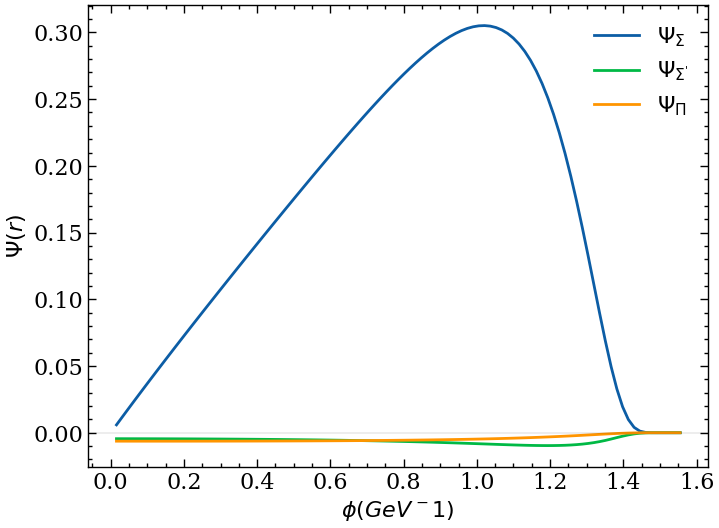

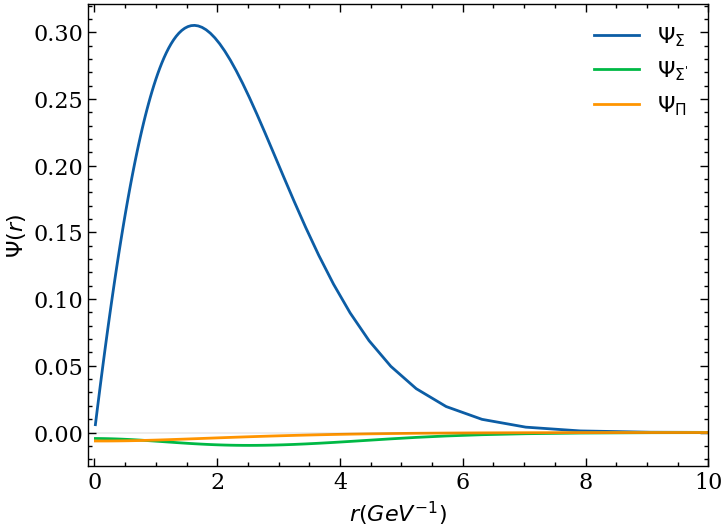

In [126]:
#I plot the 1p charmonium wavefunction

plt.plot(xi1,-qwvfX[0].real/normsX[0], label=r'$\Psi_{\Sigma}$' )
plt.plot(xi1,-sigmawvfX[0].real/normsX[0], label=r"$\Psi_{\Sigma^'}$" )
plt.plot(xi1,-piwwvfX[0].real/normsX[0], label=r'$\Psi_{\Pi}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('$\Psi_{\chi_{c1} (3872)} $')
#plt.xlim(0,12)
#plt.ylim(-2,0.2)
plt.xlabel(r'$\phi (GeV^-1)$')
plt.ylabel(r'$\Psi(r)$')
#plt.grid()
plt.legend()
plt.show()


plt.plot(np.tan(xi1),-qwvfX[0].real/normsX[0], label=r'$\Psi_{\Sigma}$' )
plt.plot(np.tan(xi1),-sigmawvfX[0].real/normsX[0], label=r"$\Psi_{\Sigma^'}$" )
plt.plot(np.tan(xi1),-piwwvfX[0].real/normsX[0], label=r'$\Psi_{\Pi}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('$\Psi_{\chi_{c1} (3872)} $')
plt.xlim(-0.1,10)
#plt.ylim(-2,0.2)
plt.xlabel(r'$r (GeV^{-1})$')
plt.ylabel(r'$\Psi(r) $')
#plt.grid()
plt.legend()
plt.show()


#plot the wavefunction in the 'usual' fm coordinates.

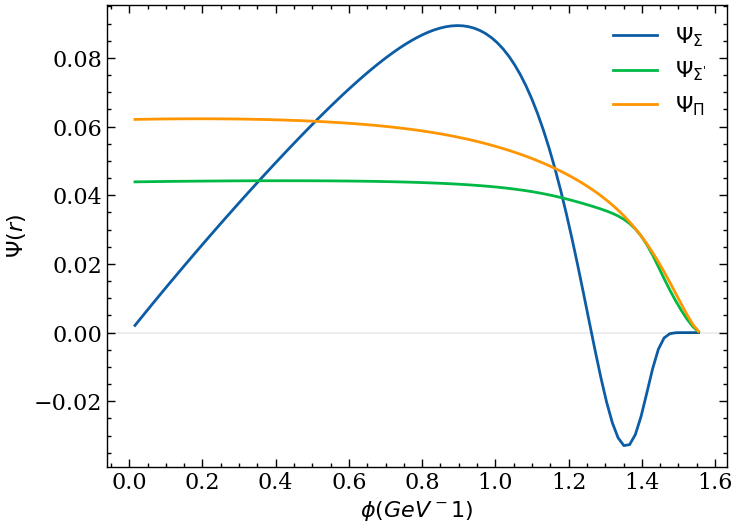

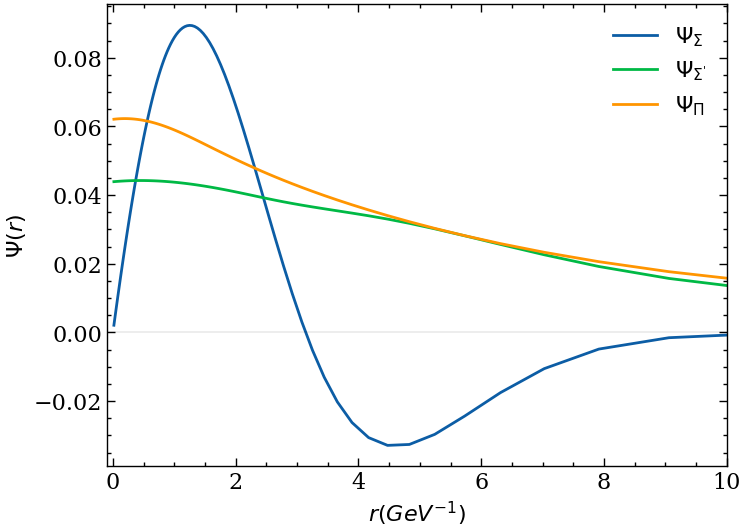

In [125]:
#I plot the X(3872) wavefunction

plt.plot(xi1,-qwvfX[1].real/normsX[1], label=r'$\Psi_{\Sigma}$' )
plt.plot(xi1,-sigmawvfX[1].real/normsX[1], label=r"$\Psi_{\Sigma^'}$" )
plt.plot(xi1,-piwwvfX[1].real/normsX[1], label=r'$\Psi_{\Pi}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('$\Psi_{\chi_{c1} (3872)} $')
#plt.xlim(0,12)
#plt.ylim(-2,0.2)
plt.xlabel(r'$\phi (GeV^-1)$')
plt.ylabel(r'$\Psi(r)$')
#plt.grid()
plt.legend()
plt.show()


plt.plot(np.tan(xi1),-qwvfX[1].real/normsX[1], label=r'$\Psi_{\Sigma}$' )
plt.plot(np.tan(xi1),-sigmawvfX[1].real/normsX[1], label=r"$\Psi_{\Sigma^'} $" )
plt.plot(np.tan(xi1),-piwwvfX[1].real/normsX[1], label=r'$\Psi_{\Pi}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('$\Psi_{\chi_{c1} (3872)} $')
plt.xlim(-0.1,10)
#plt.ylim(-2,0.2)
plt.xlabel(r'$r (GeV^{-1})$')
plt.ylabel(r'$\Psi(r) $')
#plt.grid()
plt.legend()
plt.show()

#plot the wavefunction in the 'usual'fm coordinates.

In [89]:
#Before proceeding further I compute the values of the wavefunction
#components and of their derivatives at the origin squared.
#P.N: the values of the wavefunction (squared) at the origin is 
#given in units of GeV^3 while its derivative in units of GeV^5.


#1p state
#I compute the derivative of the three components of the wavefunction
derq1p = np.gradient(qwvfX[0].real/normsX[0], xi1)
dersigma1p = np.gradient(sigmawvfX[0].real/normsX[0], xi1)
derpi1p = np.gradient(piwwvfX[0].real/normsX[0], xi1)


#I define an interpolating function for the different wavefunction
#components.
interpq1p = CubicSpline(xi1, qwvfX[0].real/normsX[0])
interpsigma1p = CubicSpline(xi1, sigmawvfX[0].real/normsX[0])
interppi1p = CubicSpline(xi1, piwwvfX[0].real/normsX[0])


#I define an interpolating function for the derivatives
interpderq1p = CubicSpline(xi1, derq1p)
interpdersigma1p = CubicSpline(xi1, dersigma1p)
interpderpi1p = CubicSpline(xi1, derpi1p)



#I determine the square of the wavefunction at the origin in two
#different ways:
#by taking the first value of the array as the value of the 
#wavefunction at the origin
#or by considering the value of the interpolating function in 
#zero.
#P.N: the value of the wavefunction components at the origin is the
#same both in r and xi coordinate (as you can notice from the plots).

q1pfirst = (qwvfX[0][0].real/normsX[0])**2
q1pinterp = interpq1p(0)**2

sigma1pfirst = (sigmawvfX[0][0].real/normsX[0])**2
sigma1pinterp = interpsigma1p(0)**2

pi1pfirst = (piwwvfX[0][0].real/normsX[0])**2
pi1pinterp = interppi1p(0)**2

print('1p state')
print('Values of the wavefunction components squared in zero')
print('quarkonium component (GeV^3)')
print(q1pfirst)
print(q1pinterp)
print('sigma tetraquark component (GeV^3)')
print(sigma1pfirst)
print(sigma1pinterp)
print('pi tetraquark component (GeV^3)')
print(pi1pfirst)
print(pi1pinterp)
print('Sum of the square of the compnents (GeV^3)')
print(q1pfirst+sigma1pfirst+pi1pfirst)
print(q1pinterp+sigma1pinterp+pi1pinterp)


#I do the same for the square of the derivatives in zero
#P.N: the derivative of the wavefunction w.r.t. r=tan(xi) in general
#is different w.r.t. the wavefunction w.r.t. xi, but these two 
#coincide in zero, as I verify in the following cell.

derq1pfirst = (derq1p[0])**2
derq1pinterp = interpderq1p(0)**2

dersigma1pfirst = (dersigma1p[0])**2
dersigma1pinterp = interpdersigma1p(0)**2

derpi1pfirst = (derpi1p[0])**2
derpi1pinterp = interpderpi1p(0)**2


print('Values of the derivative of the wavefunction components\
 squared in zero')
print('quarkonium component (GeV^5)')
print(derq1pfirst)
print(derq1pinterp)
print('sigma tetraquark component (GeV^5)')
print(dersigma1pfirst)
print(dersigma1pinterp)
print('pi tetraquark component (GeV^5)')
print(derpi1pfirst)
print(derpi1pinterp)
print('Sum of the square of the components (GeV^5)')
print(derq1pfirst+dersigma1pfirst+derpi1pfirst)
print(derq1pinterp+dersigma1pinterp+derpi1pinterp)




1p state
Values of the wavefunction components squared in zero
quarkonium component (GeV^3)
3.470653613954228e-05
2.213716826258575e-13
sigma tetraquark component (GeV^3)
2.0023007094319406e-05
1.999544513315325e-05
pi tetraquark component (GeV^3)
4.003344877898259e-05
3.9990922116405404e-05
Sum of the square of the compnents (GeV^3)
9.476299201284428e-05
5.998636747093033e-05
Values of the derivative of the wavefunction components squared in zero
quarkonium component (GeV^5)
0.1388159077622917
0.13771101301431307
sigma tetraquark component (GeV^5)
6.993443330560892e-08
9.479674260673443e-08
pi tetraquark component (GeV^5)
3.360341237243989e-08
2.6854331365349622e-08
Sum of the square of the components (GeV^5)
0.13881601130013738
0.13771113466538704


In [135]:
#cross-check for the derivatives (I compute the derivatives
#w.r.t. r and verify that coincide with the one w.r.t. xi at the
#origin).

derq1pbis = np.gradient(qwvfX[0].real/normsX[0], np.tan(xi1))
dersigma1pbis = np.gradient(sigmawvfX[0].real/normsX[0], np.tan(xi1))
derpi1pbis = np.gradient(piwwvfX[0].real/normsX[0], np.tan(xi1))

#I define an interpolating function for the derivatives
interpderq1pbis = CubicSpline(np.tan(xi1), derq1pbis)
interpdersigma1pbis = CubicSpline(np.tan(xi1), dersigma1pbis)
interpderpi1pbis = CubicSpline(np.tan(xi1), derpi1pbis)

#I determine the square of the derivatives in zero
print('Derivatives cross-checks')
print('quarkonium component (GeV^5)')
print(derq1pbis[0]**2)
print(interpderq1pbis(0)**2)
print('sigma tetraquark component (GeV^5)')
print(dersigma1pbis[0]**2)
print(interpdersigma1pbis(0)**2)
print('pi tetraquark component (GeV^5)')
print(derpi1pbis[0]**2)
print(interpderpi1pbis(0)**2)


#we have perferct agreement with the derivatives computed w.r.t.
#the xi variable.

#I finally verify that the sum of the derivative coincides with the
#derivative of quarkonium component, being the ones of the tetraquark
#components negligible.
print('cross-check')
derq1ptot = np.gradient((qwvfX[0].real+sigmawvfX[0].real+piwwvfX[0].real)/normsX[0], np.tan(xi1))
print(derq1ptot[0]**2)




Derivatives cross-checks
quarkonium component (GeV^5)
0.13865613579763678
0.1374002709343185
sigma tetraquark component (GeV^5)
6.985394051335289e-08
9.454805155070793e-08
pi tetraquark component (GeV^5)
3.356473672819121e-08
2.6801580215419238e-08
cross-check
0.13832306455167712


In [122]:
#I do the same for the X(3872) state.


#X state
#I compute the derivative of the three components of the wavefunction
derqXp = np.gradient(qwvfX[1].real/normsX[1], xi1)
dersigmaXp = np.gradient(sigmawvfX[1].real/normsX[1], xi1)
derpiXp = np.gradient(piwwvfX[1].real/normsX[1], xi1)


#I define an interpolating function for the different wavefunction
#components.
interpqXp = CubicSpline(xi1, qwvfX[1].real/normsX[1])
interpsigmaXp = CubicSpline(xi1, sigmawvfX[1].real/normsX[1])
interppiXp = CubicSpline(xi1, piwwvfX[1].real/normsX[1])


#I define an interpolating function for the derivatives
interpderqXp = CubicSpline(xi1, derqXp)
interpdersigmaXp = CubicSpline(xi1, dersigmaXp)
interpderpiXp = CubicSpline(xi1, derpiXp)



#I determine the square of the wavefunction at the origin in two
#different ways:
#by taking the first value of the array as the value of the 
#wavefunction at the origin
#or by considering the value of the interpolating function in 
#zero.
#P.N: the value of the wavefunction components at the origin is the
#same both in r and xi coordinate (as you can notice from the plots).

qXpfirst = (qwvfX[1][0].real/normsX[1])**2
qXpinterp = interpqXp(0)**2

sigmaXpfirst = (sigmawvfX[1][0].real/normsX[1])**2
sigmaXpinterp = interpsigmaXp(0)**2

piXpfirst = (piwwvfX[1][0].real/normsX[1])**2
piXpinterp = interppiXp(0)**2

print('X state')
print('Values of the wavefunction components squared in zero')
print('quarkonium component (GeV^3)')
print(qXpfirst)
print(qXpinterp)
print('sigma tetraquark component (GeV^3)')
print(sigmaXpfirst)
print(sigmaXpinterp)
print('pi tetraquark component (GeV^3)')
print(piXpfirst)
print(piXpinterp)
print('Sum of the square of the components (GeV^3)')
print(qXpfirst+sigmaXpfirst+piXpfirst)
print(qXpinterp+sigmaXpinterp+piXpinterp)



#I do the same for the square of the derivatives in zero
derqXpfirst = (derqXp[0])**2
derqXpinterp = interpderqXp(0)**2

dersigmaXpfirst = (dersigmaXp[0])**2
dersigmaXpinterp = interpdersigmaXp(0)**2

derpiXpfirst = (derpiXp[0])**2
derpiXpinterp = interpderpiXp(0)**2


print('Values of the derivative of the wavefunction components\
 squared in zero')
print('quarkonium component (GeV^5)')
print(derqXpfirst)
print(derqXpinterp)
print('sigma tetraquark component (GeV^5)')
print(dersigmaXpfirst)
print(dersigmaXpinterp)
print('pi tetraquark component (GeV^5)')
print(derpiXpfirst)
print(derpiXpinterp)
print('Sum of the square of the components (GeV^5)')
print(derqXpfirst+dersigmaXpfirst+derpiXpfirst)
print(derqXpinterp+dersigmaXpinterp+derpiXpinterp)





X state
Values of the wavefunction components squared in zero
quarkonium component (GeV^3)
4.365821361491615e-06
2.067134536627969e-14
sigma tetraquark component (GeV^3)
0.0019277115814471046
0.001925559086643033
pi tetraquark component (GeV^3)
0.003855331078431106
0.0038511184548637636
Sum of the square of the compnents (GeV^3)
0.005787408481239702
0.005776677541527468
Values of the derivative of the wavefunction components squared in zero
quarkonium component (GeV^5)
0.017458526999724524
0.0173150059201319
sigma tetraquark component (GeV^5)
2.2677875492057343e-06
2.1646953284018204e-06
pi tetraquark component (GeV^5)
3.9143435331341465e-06
3.4726490420764246e-06
Sum of the square of the components (GeV^5)
0.017464709130806864
0.01732064326450238


In [123]:
#cross-check for the derivatives (I compute the derivatives 
#w.r.t. r and verify that coincide with the one w.r.t. xi at the
#origin).

derqXpbis = np.gradient(qwvfX[1].real/normsX[1], np.tan(xi1))
dersigmaXpbis = np.gradient(sigmawvfX[1].real/normsX[1], np.tan(xi1))
derpiXpbis = np.gradient(piwwvfX[1].real/normsX[1], np.tan(xi1))

#I define an interpolating function for the derivatives
interpderqXpbis = CubicSpline(np.tan(xi1), derqXpbis)
interpdersigmaXpbis = CubicSpline(np.tan(xi1), dersigmaXpbis)
interpderpiXpbis = CubicSpline(np.tan(xi1), derpiXpbis)

#I determine the square of the derivatives in zero
print('Derivatives cross-checks')
print('quarkonium component (GeV^5)')
print(derqXpbis[0]**2)
print(interpderqXpbis(0)**2)
print('sigma tetraquark component (GeV^5)')
print(dersigmaXpbis[0]**2)
print(interpdersigmaXpbis(0)**2)
print('pi tetraquark component (GeV^5)')
print(derpiXpbis[0]**2)
print(interpderpiXpbis(0)**2)


#we have perferct agreement with the derivatives computed w.r.t.
#the xi variable.



Derivatives cross-checks
quarkonium component (GeV^5)
0.017438432883861286
0.017275920015942053
sigma tetraquark component (GeV^5)
2.2651774100016847e-06
2.1599201629129032e-06
pi tetraquark component (GeV^5)
3.909838269174332e-06
3.4653238391124126e-06


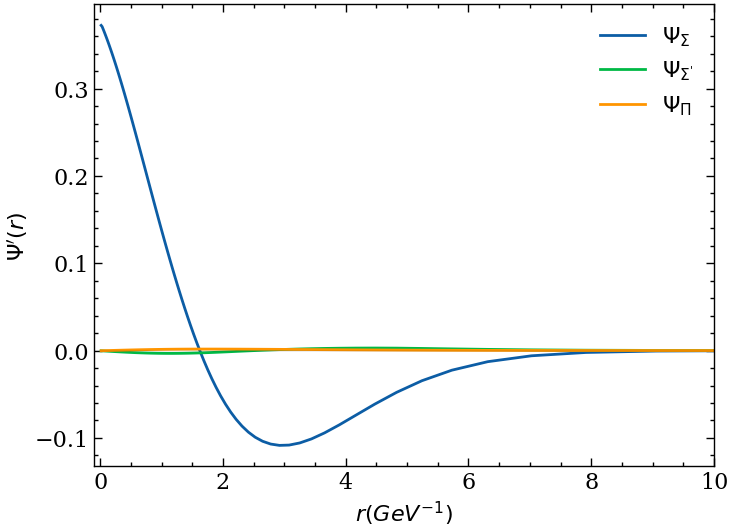

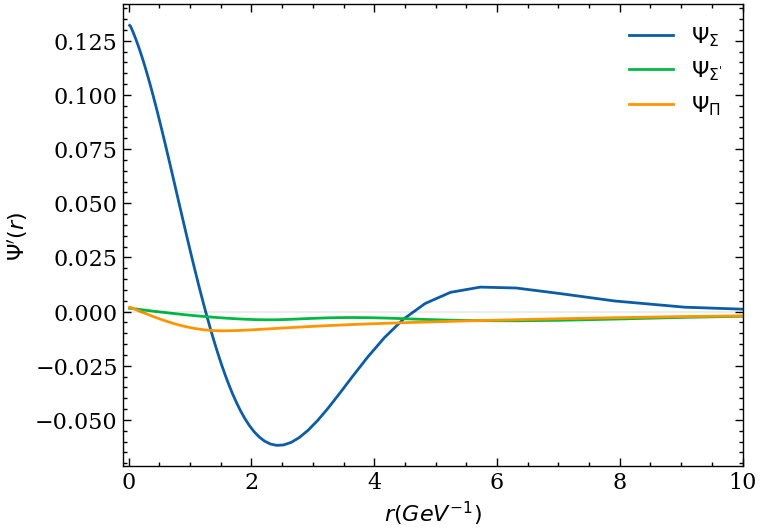

In [133]:
#I finally plot the derivatives in GeV^-1 coordinates.

#1p state
plt.plot(np.tan(xi1),-derq1pbis, label=r'$\Psi_{\Sigma}$' )
plt.plot(np.tan(xi1),-dersigma1pbis, label=r"$\Psi_{\Sigma^'}$" )
plt.plot(np.tan(xi1),-derpi1pbis, label=r'$\Psi_{\Pi}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('$\Psi_{\chi_{c1} (3872)} $')
plt.xlim(-0.1,10)
#plt.ylim(-2,0.2)
plt.xlabel(r'$r (GeV^{-1})$')
plt.ylabel(r'$\Psi^\prime(r) $')
#plt.grid()
plt.legend()
plt.show()



#X state
plt.plot(np.tan(xi1),-derqXpbis, label=r'$\Psi_{\Sigma}$' )
plt.plot(np.tan(xi1),-dersigmaXpbis, label=r"$\Psi_{\Sigma^'} $" )
plt.plot(np.tan(xi1),-derpiXpbis, label=r'$\Psi_{\Pi}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('$\Psi_{\chi_{c1} (3872)} $')
plt.xlim(-0.1,10)
#plt.ylim(-2,0.2)
plt.xlabel(r'$r (GeV^{-1})$')
plt.ylabel(r'$\Psi^\prime(r) $')
#plt.grid()
plt.legend()
plt.show()






In [ ]:
#Here I now solve the S-, D-wave Schrodinger equation and verify
#that there are no exotic solutions.


#D-wave Schrodinger equation
eigenvalueXd, qpercXd, sigmapercXd, pipercXd, qwvfXd, sigmawvfXd, piwwvfXd,\
      normsXd, invradiusXd, radiusXd, bindingXd = solverfin(2, 2, 2,
        mc, VCornc, Vsigmag, Vpig, Vmixdiab, 2, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXd)

print('Bound state radius from 1/r (fm)')
print(1/invradiusXd)

print('Bound state radius (fm)')
print(radiusXd)

print('Mass of the state (GeV)')
print(EDbarD + (eigenvalueXd -E1 - a1/mc))

print('Composition')
print(qpercXd)
print(sigmapercXd)
print(pipercXd)
print(qpercXd+sigmapercXd+pipercXd)

print('Binding energy w.r.t. the static threshold (KeV)')
print(eigenvalueXd-E1)

print('Binding energy w.r.t. the physical threshold (KeV)')
print(bindingXd*10**6)



Eigenvalue (GeV)
[-0.1226065  0.0054211]
Bound state radius from 1/r (fm)
[ 0.66047045 11.83411257]
Bound state radius (fm)
[ 0.76149547 12.30122084]
Mass of the state (GeV)
[3.8189814 3.947009 ]
Composition
[9.86381440e-01 6.34144264e-07]
[0.01186577 0.40001133]
[0.00175279 0.59998804]
[1. 1.]
Binding energy w.r.t. the static threshold (KeV)
[-0.1276065  0.0004211]
Binding energy w.r.t. the physical threshold (KeV)
[-127018.60320454    1009.00051715]


In [ ]:
#S-wave Schrodinger equation
eigenvalueXs, qpercXs, sigmapercXs, qwvfXs, sigmawvfXs,\
      normsXs, invradiusXs, radiusXs, bindingXs = solversigma(0, 0,
        mc, VCornc, Vsigmag, Vmixdiab, 3, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXs)

print('Bound state radius from 1/r (fm)')
print(1/invradiusXs)

print('Bound state radius (fm)')
print(radiusXs)

print('Mass of the state (GeV)')
print(EDbarD + (eigenvalueXs -E1 - a1/mc))

print('Composition')
print(qpercXs)
print(sigmapercXs)
print(qpercXs+sigmapercXs)

print('Binding energy w.r.t. the static threshold (KeV)')
print(eigenvalueXs-E1)

print('Binding energy w.r.t. the physical threshold (KeV)')
print(bindingXs*10**6)


Eigenvalue (GeV)
[-0.81401107 -0.23532973  0.00542089]
Bound state radius from 1/r (fm)
[ 0.24463161  0.41668622 11.82519823]
Bound state radius (fm)
[ 0.3729529   0.73990503 12.2991424 ]
Mass of the state (GeV)
[3.12757683 3.70625817 3.94700879]
Composition
[9.99656179e-01 9.89596116e-01 1.82576031e-06]
[3.43820503e-04 1.04038836e-02 9.99998174e-01]
[1. 1. 1.]
Binding energy w.r.t. the static threshold (KeV)
[-8.19011068e-01 -2.40329725e-01  4.20893104e-04]
Binding energy w.r.t. the physical threshold (KeV)
[-818423.17164789 -239741.8288808     1008.78962253]


I solve the same Schrodinger equation in the bottom sector

In [ ]:
eigenvalueXb, qpercXb, sigmapercXb, pipercXb, qwvfXb, sigmawvfXb, piwwvfXb,\
      normsXb, invradiusXb, radiusXb, bindingXb = solverfin(1, 1, 1,
        mb, VCornc, Vsigmag, Vpig, Vmixdiab, 4, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXb)
#print(eigenvalueT - 10)

print('Bound state radius from 1/r (fm)')
print(1/invradiusXb)

print('Bound state radius (fm)')
print(radiusXb)

print('Mass of the state (GeV)')
print(EBbarB + (eigenvalueXb -E1 - a1/mb))

print('Composition')
print(qpercXb)
print(sigmapercXb)
print(pipercXb)
print(qpercXb+sigmapercXb+pipercXb)

print('Binding energy w.r.t. the static threshold (GeV)')
print(eigenvalueXb-E1)

print('Binding energy w.r.t. the physical threshold (GeV)')
print(bindingXb)


Eigenvalue (GeV)
[-0.73933476 -0.38720833 -0.10598559 -0.00876419]
Bound state radius from 1/r (fm)
[0.30707775 0.41807123 0.51527224 0.4555616 ]
Bound state radius (fm)
[0.38526306 0.62058397 0.82996163 0.77499725]
Mass of the state (GeV)
[ 9.88288356 10.23500998 10.51623273 10.61345412]
Composition
[0.99939929 0.99531587 0.95839981 0.01451312]
[0.00058425 0.00464651 0.04070994 0.44943745]
[1.64625050e-05 3.76229888e-05 8.90248791e-04 5.36049429e-01]
[1. 1. 1. 1.]
Binding energy w.r.t. the static threshold (GeV)
[-0.74433476 -0.39220833 -0.11098559 -0.01376419]
Binding energy w.r.t. the physical threshold (GeV)
[-0.74411644 -0.39199002 -0.11076727 -0.01354588]


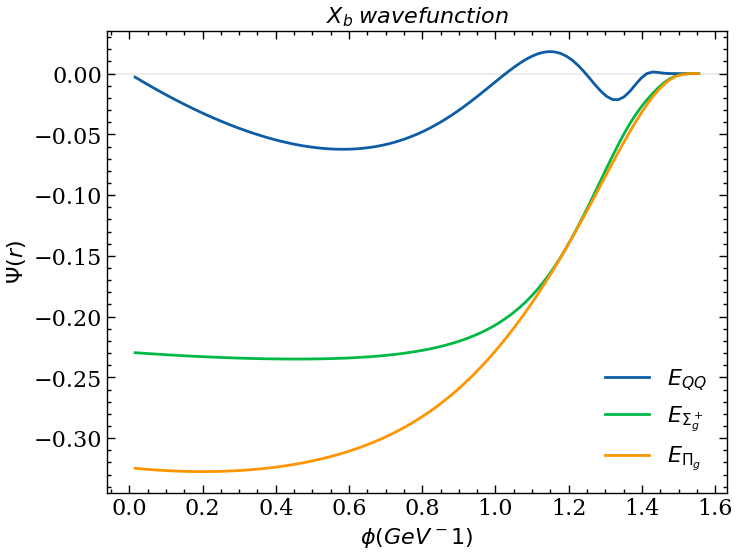

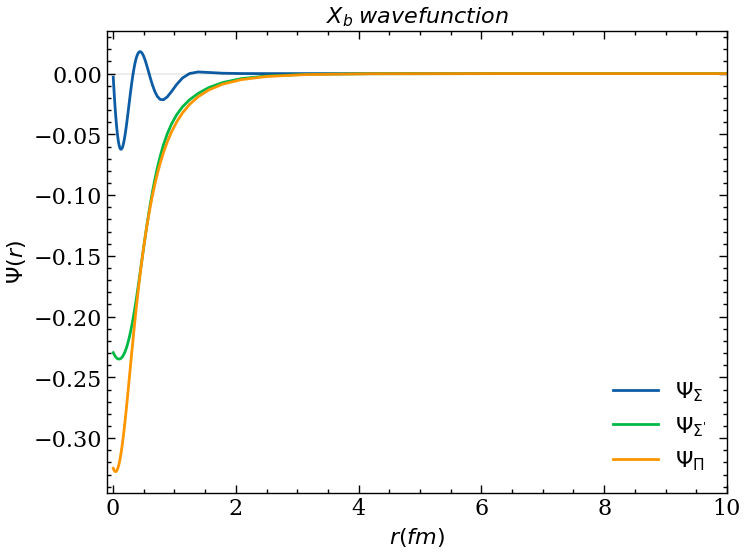

In [ ]:
plt.plot(xi1,qwvfXb[3].real/normsXb[3], label=r'$E_{QQ}$' )
plt.plot(xi1,sigmawvfXb[3].real/normsXb[3], label=r'$E_{\Sigma_g^+}$' )
plt.plot(xi1,piwwvfXb[3].real/normsXb[3], label=r'$E_{\Pi_g}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
plt.title(r'$X_b \; wavefunction$')
#plt.xlim(0,12)
#plt.ylim(-2,0.2)
plt.xlabel(r'$\phi (GeV^-1)$')
plt.ylabel(r'$\Psi(r) $')
#plt.grid()
plt.legend()
plt.show()


plt.plot(np.tan(xi1)*0.197327,qwvfXb[3].real/normsXb[3], label=r'$\Psi_{\Sigma}$' )
plt.plot(np.tan(xi1)*0.197327,sigmawvfXb[3].real/normsXb[3], label=r"$\Psi_{\Sigma^'} $" )
plt.plot(np.tan(xi1)*0.197327,piwwvfXb[3].real/normsXb[3], label=r'$\Psi_{\Pi}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
plt.title(r'$X_b \; wavefunction$')
plt.xlim(-0.1,10)
#plt.ylim(-2,0.2)
plt.xlabel(r'$r (fm)$')
plt.ylabel(r'$\Psi(r) $')
#plt.grid()
plt.legend()
plt.show()

#plot the wavefunction in the 'usual' coordinates.

In [ ]:
#I verify that the next solution is above threshold
eigenvalueXb, qpercXb, sigmapercXb, pipercXb, qwvfXb, sigmawvfXb, piwwvfXb,\
      normsXb, invradiusXb, radiusXb, bindingXb = solverfin(1, 1, 1,
        mb, VCornc, Vsigmag, Vpig, Vmixdiab, 5, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXb)

Eigenvalue (GeV)
[-0.73933476 -0.38720833 -0.10598559 -0.00876419  0.00504686]


In [ ]:
#Here I now solve the S-, D-wave Schrodinger equation and verify
#that there are no exotic solutions.


#D-wave Schrodinger equation
eigenvalueXbd, qpercXbd, sigmapercXbd, pipercXbd, qwvfXbd, sigmawvfXbd, piwwvfXbd,\
      normsXbd, invradiusXbd, radiusXbd, bindingXbd = solverfin(2, 2, 2,
        mb, VCornc, Vsigmag, Vpig, Vmixdiab, 3, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXbd)

print('Bound state radius from 1/r (fm)')
print(1/invradiusXbd)

print('Bound state radius (fm)')
print(radiusXbd)

print('Mass of the state (GeV)')
print(EBbarB + (eigenvalueXbd -E1 - a1/mb))

print('Composition')
print(qpercXbd)
print(sigmapercXbd)
print(pipercXbd)
print(qpercXbd+sigmapercXbd+pipercXbd)

print('Binding energy w.r.t. the static threshold (KeV)')
print(eigenvalueXbd-E1)

print('Binding energy w.r.t. the physical threshold (KeV)')
print(bindingXbd*10**6)





Eigenvalue (GeV)
[-0.49776943 -0.20326067  0.00515607]
Bound state radius from 1/r (fm)
[ 0.44550324  0.54437178 11.79303212]
Bound state radius (fm)
[ 0.51635304  0.73332089 12.29259929]
Mass of the state (GeV)
[10.12444889 10.41895765 10.62737439]
Composition
[9.98175002e-01 9.87101997e-01 1.51884906e-05]
[0.0017669  0.01260169 0.40007745]
[5.80960203e-05 2.96311515e-04 5.99907364e-01]
[1. 1. 1.]
Binding energy w.r.t. the static threshold (KeV)
[-5.02769428e-01 -2.08260671e-01  1.56068491e-04]
Binding energy w.r.t. the physical threshold (KeV)
[-5.02551111e+05 -2.08042354e+05  3.74385795e+02]


In [ ]:
#S-wave Schrodinger equation
eigenvalueXbs, qpercXbs, sigmapercXbs, qwvfXbs, sigmawvfXbs,\
      normsXbs, invradiusXbs, radiusXbs, bindingXbs = solversigma(0, 0,
        mb, VCornc, Vsigmag, Vmixdiab, 5, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXbs)

print('Bound state radius from 1/r (fm)')
print(1/invradiusXbs)

print('Bound state radius (fm)')
print(radiusXbs)

print('Mass of the state (GeV)')
print(EBbarB + (eigenvalueXbs -E1 - a1/mb))

print('Composition')
print(qpercXbs)
print(sigmapercXbs)
print(qpercXbs+sigmapercXbs)

print('Binding energy w.r.t. the static threshold (KeV)')
print(eigenvalueXbs-E1)

print('Binding energy w.r.t. the physical threshold (KeV)')
print(bindingXbs*10**6)

#I do not find exotic bound state solutions.


Eigenvalue (GeV)
[-1.17733616 -0.634481   -0.29455463 -0.02857776  0.00515642]
Bound state radius from 1/r (fm)
[ 0.13360211  0.27174976  0.36797713  0.50139819 11.83692759]
Bound state radius (fm)
[ 0.21424169  0.48120489  0.70249036  0.96781628 12.30249168]
Mass of the state (GeV)
[ 9.44488215  9.98773731 10.32766369 10.59364056 10.62737474]
Composition
[9.99933212e-01 9.98592651e-01 9.90637143e-01 7.87630334e-01
 1.26111671e-05]
[6.67875306e-05 1.40734927e-03 9.36285746e-03 2.12369666e-01
 9.99987389e-01]
[1. 1. 1. 1. 1.]
Binding energy w.r.t. the static threshold (KeV)
[-1.18233616e+00 -6.39481005e-01 -2.99554632e-01 -3.35777571e-02
  1.56423089e-04]
Binding energy w.r.t. the physical threshold (KeV)
[-1.18211785e+06 -6.39262687e+05 -2.99336315e+05 -3.33594398e+04
  3.74740392e+02]


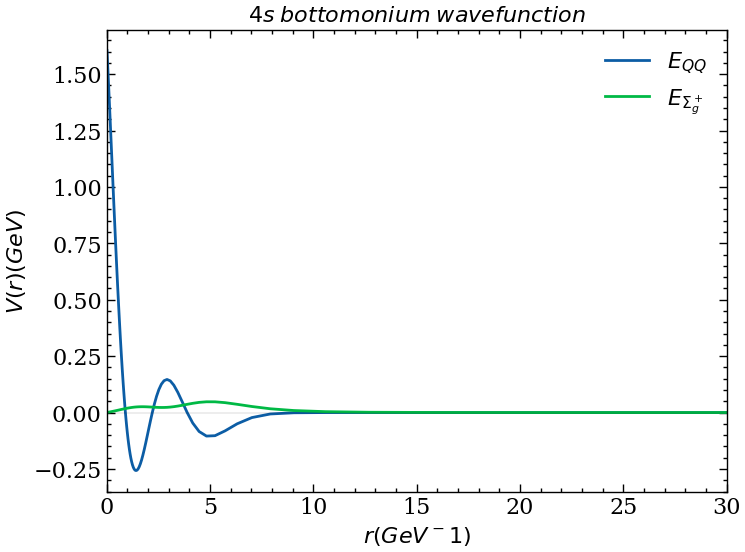

In [ ]:
#I plot the wavefunction relative to the 4s state

plt.plot(np.tan(xi1),qwvfXbs[3].real/normsXbs[3], label=r'$E_{QQ}$' )
plt.plot(np.tan(xi1),sigmawvfXbs[3].real/normsXbs[3], label=r'$E_{\Sigma_g^+}$' )
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
plt.title(r'$4s \;bottomonium \;wavefunction$')
plt.xlim(0,30)
#plt.ylim(0,30)
plt.xlabel(r'$r (GeV^-1)$')
plt.ylabel(r'$V(r) (GeV)$')
#plt.grid()
plt.legend()
plt.show()


I finally solve the Schrodinger equation in the bc sector

In [ ]:
#P-wave Schrodinger equation
eigenvalueXbc, qpercXbc, sigmapercXbc, pipercXbc, qwvfXbc, sigmawvfXbc, piwwvfXbc,\
      normsXbc, invradiusXbc, radiusXbc, bindingXbc = solverfin(1, 1, 1,
        mred, VCornc, Vsigmag, Vpig, Vmixdiab, 3, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXbc)
#print(eigenvalueT - 10)

print('Bound state radius from 1/r (fm)')
print(1/invradiusXbc)

print('Bound state radius (fm)')
print(radiusXbc)

print('Mass of the state (GeV)')
print(EDB + (eigenvalueXbc -E1 - a1/mred))

print('Composition')
print(qpercXbc)
print(sigmapercXbc)
print(pipercXbc)
print(qpercXbc+sigmapercXbc+pipercXbc)

print('Binding energy w.r.t. the static threshold (KeV)')
print(eigenvalueXbc-E1)

print('Binding energy w.r.t. the physical threshold (GeV)')
print(bindingXbc)


#P.N: the last solution is just below the static threshold but gets
#shifted above threshold due to the kinetic term.
#We do not identify it as a reliable bound state solution.



Eigenvalue (GeV)
[-0.53770969 -0.13636954  0.00497005]
Bound state radius from 1/r (fm)
[0.4059001  0.53989382 3.04824188]
Bound state radius (fm)
[0.50367245 0.79447997 8.17441396]
Mass of the state (GeV)
[6.74469342 7.14603357 7.28737316]
Composition
[0.99847209 0.9753246  0.0024859 ]
[0.00145803 0.02341584 0.34505111]
[6.98864425e-05 1.25955883e-03 6.52462984e-01]
[1. 1. 1.]
Binding energy w.r.t. the static threshold (KeV)
[-5.42709689e-01 -1.41369542e-01 -2.99461536e-05]
Binding energy w.r.t. the physical threshold (GeV)
[-5.42306582e-01 -1.40966435e-01  3.73160758e-04]


In [ ]:
#D-wave Schrodinger equation
eigenvalueXbcd, qpercXbcd, sigmapercXbcd, pipercXbcd, qwvfXbcd, sigmawvfXbcd, piwwvfXbcd,\
      normsXbcd, invradiusXbcd, radiusXbcd, bindingXbcd = solverfin(2, 2, 2,
        mred, VCornc, Vsigmag, Vpig, Vmixdiab, 2, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXbcd)

print('Bound state radius from 1/r (fm)')
print(1/invradiusXbcd)

print('Bound state radius (fm)')
print(radiusXbcd)

print('Mass of the state (GeV)')
print(EDB + (eigenvalueXbcd -E1 - a1/mred))

print('Composition')
print(qpercXbcd)
print(sigmapercXbcd)
print(pipercXbcd)
print(qpercXbcd+sigmapercXbcd+pipercXbcd)

print('Binding energy w.r.t. the static threshold (KeV)')
print(eigenvalueXbcd-E1)

print('Binding energy w.r.t. the physical threshold (KeV)')
print(bindingXbcd*10**6)




Eigenvalue (GeV)
[-0.27506964  0.00528859]
Bound state radius from 1/r (fm)
[ 0.57046577 11.82445187]
Bound state radius (fm)
[ 0.65823385 12.29906636]
Mass of the state (GeV)
[7.00733347 7.2876917 ]
Composition
[9.94643334e-01 3.69288641e-06]
[0.0050003  0.40002653]
[3.56368294e-04 5.99969778e-01]
[1. 1.]
Binding energy w.r.t. the static threshold (KeV)
[-0.28006964  0.00028859]
Binding energy w.r.t. the physical threshold (KeV)
[-279666.53252271     691.7012215 ]


In [ ]:
#S-wave Schrodinger equation
eigenvalueXbcs, qpercXbcs, sigmapercXbcs, qwvfXbcs, sigmawvfXbcs,\
      normsXbcs, invradiusXbcs, radiusXbcs, bindingXbcs = solversigma(0, 0,
        mred, VCornc, Vsigmag, Vmixdiab, 4, xi, dxi)


#Grid details: # of points = 100


print('Eigenvalue (GeV)')
print(eigenvalueXbcs)

print('Bound state radius from 1/r (fm)')
print(1/invradiusXbcs)

print('Bound state radius (fm)')
print(radiusXbcs)

print('Mass of the state (GeV)')
print(EDB + (eigenvalueXbcs -E1 - a1/mred))

print('Composition')
print(qpercXbcs)
print(sigmapercXbcs)
print(qpercXbcs+sigmapercXbcs)

print('Binding energy w.r.t. the static threshold (KeV)')
print(eigenvalueXbcs-E1)

print('Binding energy w.r.t. the physical threshold (KeV)')
print(bindingXbcs*10**6)

#I do not find exotic bound state solutions.


Eigenvalue (GeV)
[-0.94487227 -0.39433151 -0.0192207   0.00528902]
Bound state radius from 1/r (fm)
[ 0.1982565   0.35548939  0.52056234 11.84312562]
Bound state radius (fm)
[ 0.30752236  0.63259664  0.99123337 12.30511177]
Mass of the state (GeV)
[6.33753084 6.8880716  7.26318241 7.28769213]
Composition
[9.99805068e-01 9.95555848e-01 8.09965915e-01 2.65966077e-05]
[1.94932083e-04 4.44415198e-03 1.90034085e-01 9.99973403e-01]
[1. 1. 1. 1.]
Binding energy w.r.t. the static threshold (KeV)
[-9.49872270e-01 -3.99331506e-01 -2.42207002e-02  2.89021953e-04]
Binding energy w.r.t. the physical threshold (KeV)
[-9.49469163e+05 -3.98928399e+05 -2.38175933e+04  6.92128864e+02]


In this part of the code I compare the potentials that we used here to solve the Schrodinger equation with those plotted in the paper.

In [36]:
#Here I define the grid that I use for my plots
Nr = 100000
rmax = 100
rmin=0
r = np.linspace(rmin, rmax, Nr+1)
r1=r[1:-1]
dr = (rmax-rmin)/Nr

#Here I define a function to define all the static potentials 
#directly in the r coordinate.

def vsmallr(k8,delta,A,B,r):
    return k8/r + delta + A*r**2 + B*r**4

def vlarger(F,reff,E1,r):
    return F*np.exp(-(r/reff))/r**2 + E1


def Vrepgr(k8,delta,A,B,F,reff,E1,rsmall,rlarge, shift):
    Vsmall = vsmallr(k8,delta,A,B,rsmall)
    Vlarge = vlarger(F,reff,E1,rlarge)
    Vrepg = np.concatenate((Vsmall,Vlarge)) + shift
    return Vrepg


#I define a function to define the tetraquark potential in the
#r coordinate.

def Vtetrr(k3,delta,A,B,F,reff,rmatch,E1,shift):
    rsmall = np.linspace(rmin,rmatch,int(rmatch*Nr/
                                                 (rmax-rmin))+1)[1:]
    rlarge = np.linspace(rmatch,rmax,int((rmax-rmatch)
                                                 *Nr/(rmax-rmin))+2)[1:-1]

    V = Vrepgr(k3,delta,A,B,F,
                   reff,E1,rsmall,rlarge, shift)

    return V



def vCornCr(V0, sigma, gamma, r):
    return V0  + sigma*r + gamma/r

Tcc case

In [37]:
#I summarize the parameters relative to the potential used here for
#the calculations and to the one showed in the paper.


#final potential (GeV units)
#small r parameters
k3 = -0.12 #dimensionless

Asigmagp = 0.196698 #GeV^3

Bsigmagp = -0.0449009 #GeV^5

deltap = -0.478 # GeV

#large r parameters
#two-pion exchange mass parameter
reffp = 1/0.3 #GeV^-1

Fsigmagp = -0.608724 #GeV^-1

rmatchsigmap = 1.2139 #GeV^-1
#ximatchsigmap = np.arctan(rmatchsigmap)


VsigmagpGeV = Vtetrr(k3,deltap,Asigmagp,0,
                   Fsigmagp,reffp,rmatchsigmap,0,0)




#old potential (GeV units)
#small r parameters
k3old = -0.12 #dimensionless

Asigmagpold = 0.196698 #GeV^3

Bsigmagpold = -0.0449009 #GeV^5

deltapold = -0.450 # GeV

#large r parameters
#two-pion exchange mass parameter
reffpold = 1/0.3 #GeV^-1

Fsigmagpold = -0.551142 #GeV^-1

rmatchsigmapold = 1.18219 #GeV^-1
#ximatchsigmap = np.arctan(rmatchsigmap)


VsigmagpoldGeV = Vtetrr(k3old,deltapold,Asigmagpold,0,
                   Fsigmagpold,reffpold,rmatchsigmapold,0,0)





#I convert the previous potentials in fm units.
#final potential (fm units)
#small r parameters
k3fm = k3* 0.197327 #GeV * fm

Asigmagpfm = Asigmagp/(0.197327)**2 #GeV * fm^-2

Bsigmagpfm = Bsigmagp/(0.197327)**4 #GeV * fm^-4

deltapfm = deltap

#large r parameters
#two-pion exchange mass parameter
reffpfm = reffp * 0.197327 #fm

Fsigmagpfm = Fsigmagp*(0.197327)**2  #GeV fm^2

rmatchsigmapfm = rmatchsigmap*(0.197327)  #fm
#ximatchsigmap = np.arctan(rmatchsigmap)


Vsigmagpfm = Vtetrr(k3fm,deltapfm,Asigmagpfm,0,
                   Fsigmagpfm,reffpfm,rmatchsigmapfm,0,0)





#old potential (fm units)
#small r parameters
k3oldfm = k3old* 0.197327 #GeV * fm

Asigmagpoldfm = Asigmagpold/(0.197327)**2 #GeV * fm^-2

Bsigmagpoldfm = Bsigmagpold/(0.197327)**4 #GeV * fm^-4

deltapoldfm = deltapold

#large r parameters
#two-pion exchange mass parameter
reffpoldfm = reffpold * 0.197327 #fm

Fsigmapoldfm = Fsigmagpold*(0.197327)**2  #GeV fm^2

rmatchsigmapoldfm = rmatchsigmapold*(0.197327)  #fm
#ximatchsigmap = np.arctan(rmatchsigmap)


Vsigmagpoldfm = Vtetrr(k3oldfm,deltapoldfm,Asigmagpoldfm,0,
                   Fsigmapoldfm,reffpoldfm,rmatchsigmapoldfm,0,0)



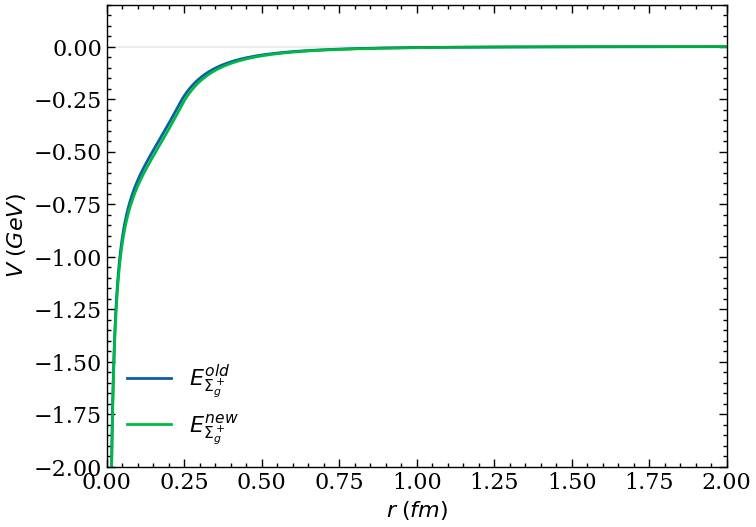

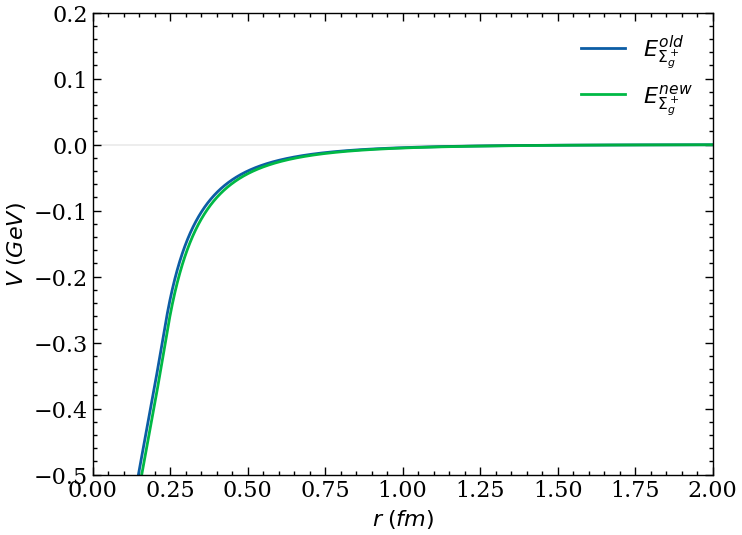

In [ ]:
#I compare the two potentials

plt.plot(r1,Vsigmagpoldfm, label=r'$E_{\Sigma_g^+}^{old}$')
plt.plot(r1,Vsigmagpfm, label=r'$E_{\Sigma_g^+}^{new}$')
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('$T_{cc} \; potential: \phi \; coord.$')
plt.xlim(0,2)
plt.ylim(-2,0.2)
plt.xlabel(r'$r \; (fm)$')
plt.ylabel(r'$V \; (GeV)$')
#plt.grid()
plt.legend()
plt.show()


#I plot the potential in this xi coordinate
plt.plot(r1,Vsigmagpoldfm, label=r'$E_{\Sigma_g^+}^{old}$')
plt.plot(r1,Vsigmagpfm, label=r'$E_{\Sigma_g^+}^{new}$')
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('$T_{cc} \; potential: \phi \; coord.$')
plt.xlim(0,2)
plt.ylim(-0.5,0.2)
plt.xlabel(r'$r \; (fm)$')
plt.ylabel(r'$V \; (GeV)$')
#plt.grid()
plt.legend()
plt.show()

#The potentials are almost indistinguishable.
#No need to make an updated plot for the paper.

X case

In [39]:
#I do the same as for Tcc case. I focus on the diabatic potentials,
#if the old and new potentials are very similar, since the mixing
#and the Cornell potential are the same, also the adiabatic levels
#will be the same.

#I focus just on the two tetraquark potentials.



#final potentials (GeV units)
#small r parameters
k8 = 0.037 # dimensionless

Asigmag = 0.00645415 #GeV^3

Bsigmag = 0.00178072 #GeV^5

Apig = 0.0725938#GeV^3

Bpig = -0.00507409 #GeV^5

#mass difference
delta = -0.228 #GeV

#large r parameters
reff = 1/0.3 #GeV^-1

Fsigmag = -1.43962 #GeV^-1
rmatchsigmag = 2.4444 #GeV^-1
#ximatchsigmap3 = np.arctan(rmatchsigmap3)

Fpig = -0.251049 #GeV^-1
rmatchpig = 1.4462 #GeV^-1


VsigmagGeV = Vtetrr(k8,delta,Asigmag,Bsigmag,
                   Fsigmag,reff,rmatchsigmag,E1,0)

VpigGeV = Vtetrr(k8,delta,Apig,Bpig,
                   Fpig,reff,rmatchpig,E1,0)




#old potential (GeV units)
#small r parameters
k8old = 0.037 # dimensionless

Asigmagold = 0.00645415 #GeV^3

Bsigmagold = 0.00178072 #GeV^5

Apigold = 0.0725938#GeV^3

Bpigold = -0.00507409 #GeV^5


#mass difference
deltaold = -0.198 # GeV

#large r parameters
reffold = 1/0.3 #GeV^-1

Fsigmagold = -1.08784 #GeV^-1
rmatchsigmagold = 2.33663 #GeV^-1
#ximatchsigmap3 = np.arctan(rmatchsigmap3)

Fpigold = -0.165609 #GeV^-1
rmatchpigold = 1.29926 #GeV^-1


VsigmagoldGeV = Vtetrr(k8old,deltaold,Asigmagold,Bsigmagold,
                   Fsigmagold,reffold,rmatchsigmagold,E1,0)

VpigoldGeV = Vtetrr(k8old,deltaold,Apigold,Bpigold,
                   Fpigold,reffold,rmatchpigold,E1,0)









#I convert the previous potentials in fm units.
#final potential (fm units)
#small r parameters
k8fm = k8 * 0.197327 #GeV * fm

Asigmagfm = Asigmag/(0.197327)**2 #GeV * fm^-2

Bsigmagfm = Bsigmag/(0.197327)**4 #GeV * fm^-4

Apigfm = Apig/(0.197327)**2 #GeV * fm^-2

Bpigfm = Bpig/(0.197327)**4 #GeV * fm^-4

#mass difference
deltafm = delta #GeV

#large r parameters
refffm = reff * 0.197327  #fm

Fsigmagfm = Fsigmag*(0.197327)**2  #GeV fm^2

#rmatchsigma6 = 2.33663 #GeV^-1
rmatchsigmagfm = rmatchsigmag * 0.197327 #fm

Fpigfm = Fpig*(0.197327)**2   #GeV fm^2

#rmatchpi6 = 1.29926 #GeV^-1
rmatchpigfm = rmatchpig * 0.197327 #fm




Vsigmagfm = Vtetrr(k8fm,deltafm,Asigmagfm,Bsigmagfm,
                   Fsigmagfm,refffm,rmatchsigmagfm,E1,0)

Vpigfm = Vtetrr(k8fm,deltafm,Apigfm,Bpigfm,
                   Fpigfm,refffm,rmatchpigfm,E1,0)





#old potential (fm units)
#small r parameters
k8oldfm = k8old * 0.197327 #GeV * fm

Asigmagoldfm = Asigmagold/(0.197327)**2 #GeV * fm^-2

Bsigmagoldfm = Bsigmagold/(0.197327)**4 #GeV * fm^-4

Apigoldfm = Apigold/(0.197327)**2 #GeV * fm^-2

Bpigoldfm = Bpigold/(0.197327)**4 #GeV * fm^-4

#mass difference
deltaoldfm = deltaold #GeV

#large r parameters
reffoldfm = reff * 0.197327  #fm

Fsigmagoldfm = Fsigmagold*(0.197327)**2  #GeV fm^2

#rmatchsigma6 = 2.33663 #GeV^-1
rmatchsigmagoldfm = rmatchsigmagold * 0.197327 #fm

Fpigoldfm = Fpigold*(0.197327)**2   #GeV fm^2

#rmatchpi6 = 1.29926 #GeV^-1
rmatchpigoldfm = rmatchpigold * 0.197327 #fm




Vsigmagoldfm = Vtetrr(k8oldfm,deltaoldfm,Asigmagoldfm,Bsigmagoldfm,
                   Fsigmagoldfm,reffoldfm,rmatchsigmagoldfm,E1,0)

Vpigoldfm = Vtetrr(k8oldfm,deltaoldfm,Apigoldfm,Bpigoldfm,
                   Fpigoldfm,reffoldfm,rmatchpigoldfm,E1,0)





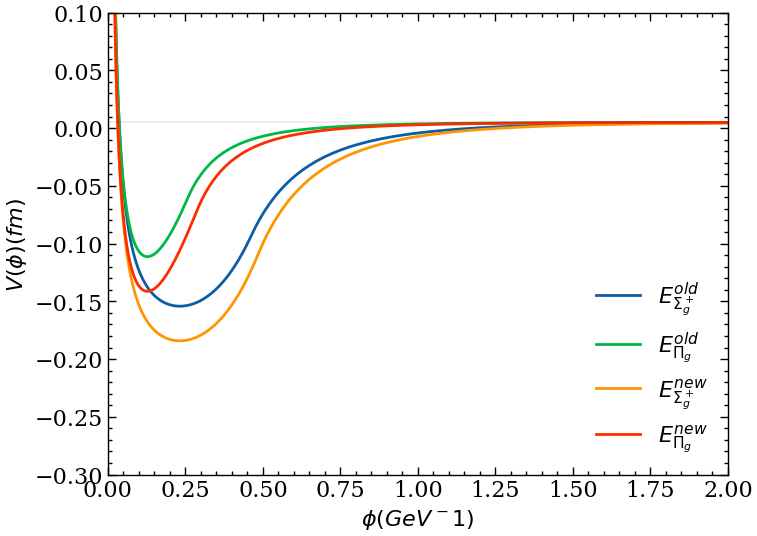

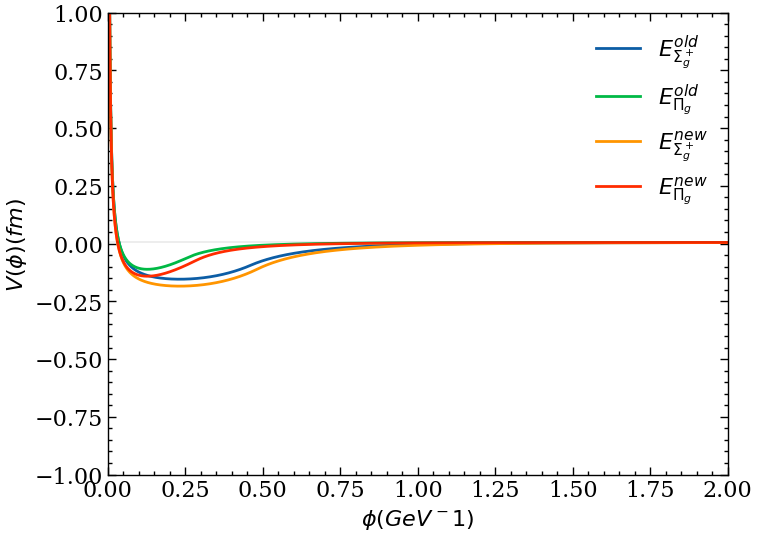

In [ ]:
#I compare the potentials
#zoomed area
plt.plot(r1,Vsigmagoldfm, label=r'$E_{\Sigma_g^+}^{old}$' )
plt.plot(r1,Vpigoldfm, label=r'$E_{\Pi_g}^{old}$')
plt.plot(r1,Vsigmagfm, label=r'$E_{\Sigma_g^+}^{new}$' )
plt.plot(r1,Vpigfm, label=r'$E_{\Pi_g}^{new}$')
plt.axhline(y = 0.005, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
plt.xlim(0,2)
plt.ylim(-0.3,0.1)
plt.xlabel(r'$\phi (GeV^-1)$')
plt.ylabel(r'$V(\phi) (fm)$')
#plt.grid()
plt.legend()
plt.show()




plt.plot(r1,Vsigmagoldfm, label=r'$E_{\Sigma_g^+}^{old}$' )
plt.plot(r1,Vpigoldfm, label=r'$E_{\Pi_g}^{old}$')
plt.plot(r1,Vsigmagfm, label=r'$E_{\Sigma_g^+}^{new}$' )
plt.plot(r1,Vpigfm, label=r'$E_{\Pi_g}^{new}$')
plt.axhline(y = 0.005, color = 'black' ,  linewidth = 0.1, linestyle = '-')
#plt.title('Static potentials: initial paramatrization')
plt.xlim(0,2)
plt.ylim(-1,1)
plt.xlabel(r'$\phi (GeV^-1)$')
plt.ylabel(r'$V(\phi) (fm)$')
#plt.grid()
plt.legend()
plt.show()

#also in this case the difference is not very apparent

In this part I also compute the spectrum of P-wave charmonium  without accounting for the mixing with the tetraquark potentials, the value of the wavefunction and its derivative at the origin.

Eigenvalues (GeV)
[-0.40310215  0.04473891  0.4190943   0.7467721   1.03645838]
Inverse bound state radius from 1/r (fm^-1)
[2.10849147 1.62267252 1.36216953 1.18786617 1.05108465]
Bound state radius (fm)
[0.58535488 0.90339633 1.17284991 1.39520003 1.67467793]
Mass of the states (GeV)
[3.53848574 3.9863268  4.36068219 4.68836    4.97804628]


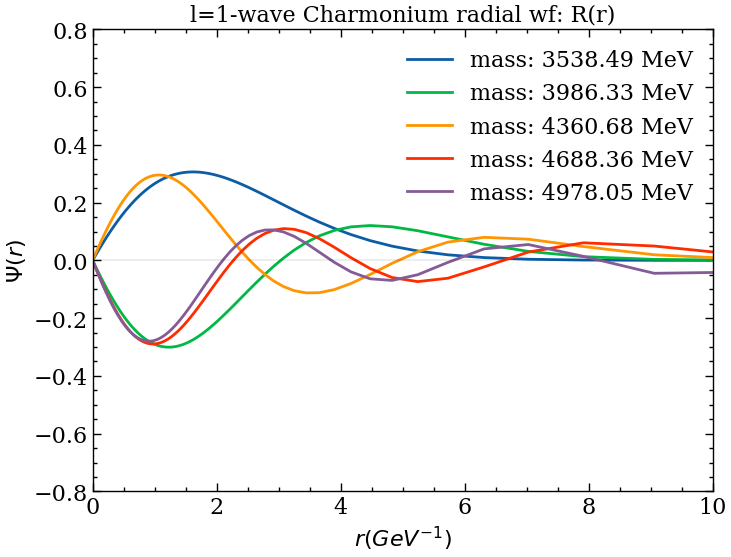

In [158]:
#P-wave charmonium
k=5
lp=1
eigenvaluecp , wvfcp, normscp, invradiuscp, radiuscp= solverTcc(lp, 
            mc, VCornc, k, xi, dxi)

#Grid details: # of points = 100

print('Eigenvalues (GeV)')
print(eigenvaluecp)

print('Inverse bound state radius from 1/r (fm^-1)')
print(invradiuscp)

print('Bound state radius (fm)')
print(radiuscp)

#I compute the actual masses of the states
masscp = EDbarD + (eigenvaluecp -E1 - a1/mc)

print('Mass of the states (GeV)')
print(masscp)

#Plot of the wavefunctions
for i in range(0,k):
    plt.plot(np.tan(xi1), wvfcp[i].real/normscp[i],\
     label=r'mass: {} MeV'.format(round(1000*masscp[i],2)))
plt.xlim(0,10)
plt.ylim(-0.8,0.8)
plt.ylabel(r'$\Psi (r) $')
plt.xlabel(r'$r (GeV^{-1})$')
plt.title(r'l={}-wave Charmonium radial wf: R(r)'.format(int(lp)))
plt.legend()
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
plt.show()




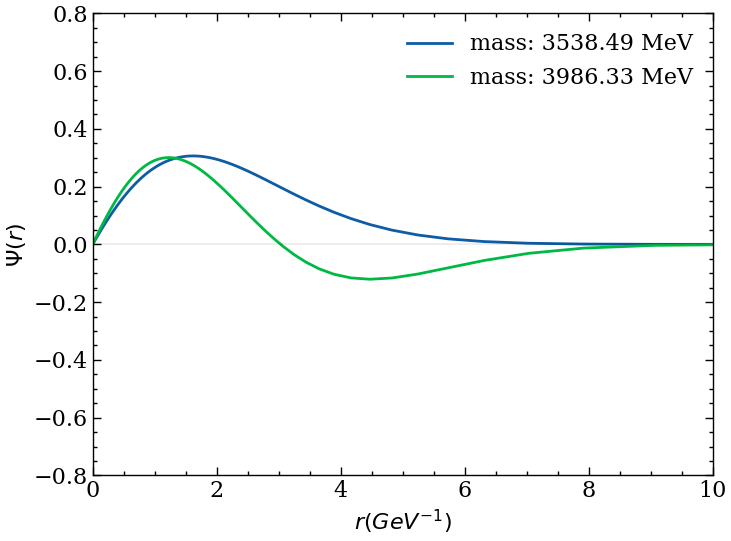

In [167]:
#Plot of the wavefunctions
plt.plot(np.tan(xi1), wvfcp[0].real/normscp[0],\
     label=r'mass: {} MeV'.format(round(1000*masscp[0],2)))
plt.plot(np.tan(xi1), -wvfcp[1].real/normscp[1],\
     label=r'mass: {} MeV'.format(round(1000*masscp[1],2)))     
plt.xlim(0,10)
plt.ylim(-0.8,0.8)
plt.ylabel(r'$\Psi (r) $')
plt.xlabel(r'$r (GeV^{-1})$')
#plt.title(r'l={}-wave Charmonium radial wf: R(r)'.format(int(lp)))
plt.legend()
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
plt.show()

In [162]:
#Here I compute the derivative of the quarkonium wavefunction 
#at the origin for the 1p and 2p state.

#1p state
der1p = np.gradient(wvfcp[0].real/normscp[0], np.tan(xi1))

#2p state
der2p = np.gradient(wvfcp[1].real/normscp[1], np.tan(xi1))

#I define an interpolating function for the wavefunctions
interp1p = CubicSpline(xi1, wvfcp[0].real/normscp[0])
interp2p = CubicSpline(xi1, wvfcp[1].real/normscp[1])

#I define an interpolating function for the derivatives
interpder1p = CubicSpline(xi1, der1p)
interpder2p = CubicSpline(xi1, der2p)



#1p state
#Square of the wavefunction at the origin
wvf1pfirst = (wvfcp[0][0].real/normscp[0])**2
wvf1pinterp = interp1p(0)**2
#Square of the derivatives of the wavefunction in zero
der1pfirst = der1p[0]**2
der1pinterp = interpder1p(0)**2


print('1p state')
print('Values of the wavefunction squared in zero')
print('quarkonium component (GeV^3)')
print(wvf1pfirst)
print(wvf1pinterp)
print('Values of the derivative if the wavefunction squared\
 in zero')
print('quarkonium component (GeV^5)')
print(der1pfirst)
print(der1pinterp)




#2p state 
#Square of the wavefunction at the origin
wvf2pfirst = (wvfcp[1][0].real/normscp[1])**2
wvf2pinterp = interp2p(0)**2
#Square of the derivatives of the wavefunction in zero
der2pfirst = der2p[0]**2
der2pinterp = interpder2p(0)**2


print('2p state')
print('Values of the wavefunction squared in zero')
print('quarkonium component (GeV^3)')
print(wvf2pfirst)
print(wvf2pinterp)
print('Values of the derivative if the wavefunction squared\
 in zero')
print('quarkonium component (GeV^5)')
print(der2pfirst)
print(der2pinterp)


1p state
Values of the wavefunction squared in zero
quarkonium component (GeV^3)
3.50464724547235e-05
2.233133628689046e-13
Values of the derivative if the wavefunction squared in zero
quarkonium component (GeV^5)
0.14001411390691743
0.1387419537768477
2p state
Values of the wavefunction squared in zero
quarkonium component (GeV^3)
5.095430040314889e-05
2.329812539875043e-13
Values of the derivative if the wavefunction squared in zero
quarkonium component (GeV^5)
0.203522760783139
0.20161468088368245


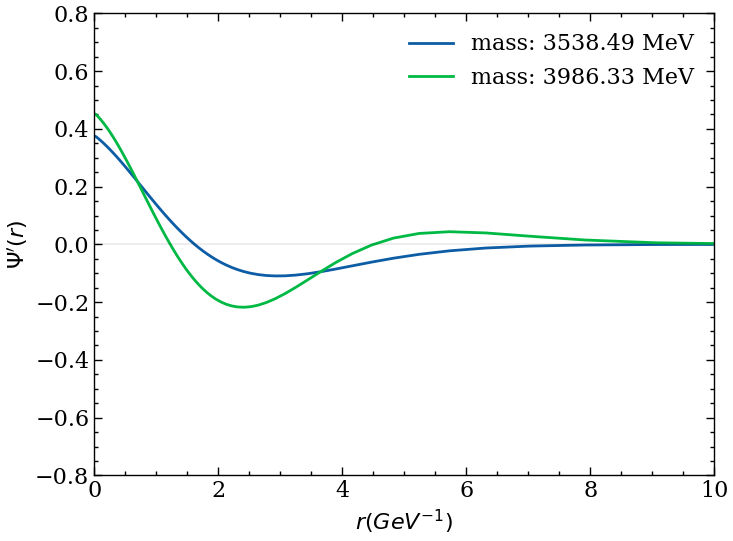

In [166]:
#I finally make a print of the two derivatives

plt.plot(np.tan(xi1), der1p,\
     label=r'mass: {} MeV'.format(round(1000*masscp[0],2)))
plt.plot(np.tan(xi1), -der2p,\
     label=r'mass: {} MeV'.format(round(1000*masscp[1],2)))     
plt.xlim(0,10)
plt.ylim(-0.8,0.8)
plt.ylabel(r'$\Psi^\prime (r) $')
plt.xlabel(r'$r (GeV^{-1})$')
#plt.title(r'l={}-wave Charmonium radial wf: R(r)'.format(int(lp)))
plt.legend()
plt.axhline(y = 0, color = 'black' ,  linewidth = 0.1, linestyle = '-')
plt.show()



